In [ ]:
!pip install py2opsin
!pip install rdkit
!pip install chemspipy
!pip install pubchempy
!pip install molvs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chemspipy: filename=ChemSpiPy-2.0.0-py3-none-any.whl size=15080 sha256=f6f3ec1cf7e31858f55f028129984f3cba88a2e496a8d049e252ced877392e42
  Stored in directory: /root/.cache/pip/wheels/7e/5c/ff/f6e7a1b7bd81f2dbadccf3fb598c421883928a8b575914795c
Successfully built chemspipy
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=0bcda98a5ee5a030837def6ff1f8c6fa7eceac096f6bc5fb66c53ae35b42ebfd
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 767.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for molvs: filename=MolVS-0.1.1-p

In [ ]:
# import required modules
import os
import ast
import re
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from py2opsin import py2opsin
import pubchempy as pcp
from chemspipy import ChemSpider
from tqdm import tqdm
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import Draw
from molvs import standardize_smiles

RDLogger.DisableLog("rdApp.*")  # ignore the rdkit warnings

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def load_data(data_dir):
    df = pd.DataFrame()
    for file_name in os.listdir(data_dir):
        if file_name.endswith(".xlsx"):
            data_path = os.path.join(data_dir, file_name)
            sub_df = pd.read_excel(data_path, engine="openpyxl")
            sub_df = sub_df[
                [
                    "Reaction ID",
                    "Reaction",
                    "Temperature (Reaction Details) [C]",
                    "Yield (numerical)",
                    "Reagent",
                    "Solvent (Reaction Details)",
                    "Catalyst",
                ]
            ]
            sub_df = sub_df[:-2]  # Remove disclaimer and copyright
            df = pd.concat([df, sub_df], ignore_index=True)
        else:
            continue

    # Drop duplications
    df = df.drop_duplicates()

    return df

In [ ]:
def preprocess_data(df):
    # remove reactions without reported yields, solvent, reaction SMILES, or temperature
    # reactions without reagents or catalysts were retained in this dataset as
    # there are known examples where, e.g., heating is sufficient for reactivity
    df = df[df["Yield (numerical)"].notna()]
    df = df[df["Solvent (Reaction Details)"].notna()]
    df = df[df["Reaction"].notna()]
    df = df[df["Temperature (Reaction Details) [C]"].notna()]

    # Separate multiple components of each reaction condition type
    col_splits = [
        "Yield (numerical)",
        "Reagent",
        "Catalyst",
        "Solvent (Reaction Details)",
    ]
    for col in col_splits:
        df[col] = df[col].str.split("; ")
    df["Yield (numerical)"] = df["Yield (numerical)"].apply(tuple)

    # split 'Reaction' into 'reactants' and 'products' by '>>' and
    df[["Reactants Smiles", "Products Smiles"]] = df["Reaction"].str.split(
        ">>", expand=True
    )
    df[["Reactants", "Products"]] = df["Reaction"].str.split(">>", expand=True)

    # split 'reactants' and 'products' into lists by '.' in place
    for col in ["Reactants", "Products"]:
        df[col] = df[col].str.split(".")

    # remove reactions without recorded structures (half reactions)
    df = df[~df["Reaction"].str.contains("^>>|>>$")]

    # remove reactants or products can not be parsed by RDKit
    passed_parsed_by_rdkit_id_list = []
    for i in range(len(df)):
        smiles_list = df.iloc[i]["Reactants"] + df.iloc[i]["Products"]
        failed_rdkit = False
        for s in smiles_list:
            if Chem.MolFromSmiles(s) is None:
                failed_rdkit = True
                break
        if not failed_rdkit:
            passed_parsed_by_rdkit_id_list.append(i)
    df = df.iloc[passed_parsed_by_rdkit_id_list]

    # concatenate 'Reagent' and 'Catalyst' columns to single 'reagents' lists
    # first replace NaN values with empty lists
    r_na = df["Reagent"].isna()
    c_na = df["Catalyst"].isna()
    df.loc[r_na, "Reagent"] = pd.Series([[]] * r_na.sum()).values
    df.loc[c_na, "Catalyst"] = pd.Series([[]] * c_na.sum()).values

    # concatenate lists and drop original columns
    df["Reagents"] = df["Reagent"] + df["Catalyst"]
    df = df.drop(["Reagent", "Catalyst"], axis=1)

    # remove duplicated reagents and solvents
    # duplicate compounds and reagents often just refer to multiple equivalents
    # duplicate solvents may refer to materials being added together as solutions
    for col in ["Reagents", "Solvent (Reaction Details)"]:
        df[col] = df[col].apply(lambda x: tuple(sorted(set(map(str.strip, x)))))

    # keep only the maximum temperature, as the reaction should occur at high temperatures
    # remove temperature details
    def find_max_temperature(x):
        numbers = re.findall(r"-?\d+", str(x))
        numbers = [int(num) for num in numbers]
        if numbers:
            return max(numbers)
        else:
            return None

    df["Max Temperature"] = df["Temperature (Reaction Details) [C]"].apply(
        find_max_temperature
    )

    # Remove duplicated reaction condition records
    df = df.drop_duplicates(
        subset=[
            "Reaction ID",
            "Max Temperature",
            "Solvent (Reaction Details)",
            "Reagents",
        ]
    )
    df = df[
        [
            "Reaction ID",
            "Reaction",
            "Temperature (Reaction Details) [C]",
            "Max Temperature",
            "Solvent (Reaction Details)",
            "Reagents",
            "Reactants",
            "Products",
            "Reactants Smiles",
            "Products Smiles",
            "Yield (numerical)",
        ]
    ]

    return df

In [ ]:
def plot_dist(df):
    for variable in [
        "Reactants",
        "Products",
        "Solvent (Reaction Details)",
        "Reagents",
        "Yield (numerical)",
    ]:
        try:
            value_counts = df[variable].map(len).value_counts()
            plt.figure(figsize=(4, 4))
            bars = plt.bar(value_counts.index, value_counts.values, width=0.6)
            plt.xticks(value_counts.index)
            # Enlarge space from the top of the bar to the top edge of the box
            plt.ylim(top=max(value_counts.values) * 1.1)
            # Add count values as labels on the bars
            for bar, count in zip(bars, value_counts.values):
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    count + 50,
                    str(count),
                    ha="center",
                    fontsize=10,
                    color="black",
                )
            plt.xlabel("Number of elements")
            plt.ylabel("Count")
            plt.title(variable)
        except:
            pass

In [ ]:
# Standardize the labels for reagents and solvents
# Check nomenclature for reagents and solvents

ChemSpider_API_Key = "Your_API_Key"
cs = ChemSpider(ChemSpider_API_Key)


def PCPconvert(name):
    s = pcp.get_compounds(name, "name")
    try:
        return s[0].canonical_smiles
    except:
        return None


def ChemSpiderConvert(name):
    results = cs.search(name)
    if len(results) == 0:
        return None
    return results[0].smiles


def OpsinConvert(name):
    result = py2opsin(name)
    if result == "":
        return None
    return result

In [ ]:
def analyze_nomenclature(df, property_name):
    # return list of all unique molecular names and frequencies
    df_all = df[property_name].explode()

    # combine into single list with counts and frequencies
    chemical_list = list(
        zip(
            df_all.value_counts().index,
            df_all.value_counts(),
            df_all.value_counts(normalize=True),
        )
    )

    # create dataframe for processing
    analyzed_df = pd.DataFrame(chemical_list, columns=["name", "count", "frequency"])

    # add column for cumulative sum of frequency
    analyzed_df["cumulative"] = analyzed_df.frequency.cumsum()

    return analyzed_df

In [ ]:
def get_name_map_dict(df, name):
    name_df = analyze_nomenclature(df, name)
    # remove the entries with rare chemicals whose count in the dataset is less than 10
    name_df = name_df[name_df["count"] >= 10]

    # Standardize the labels: I use OPSIN, PubChem, ChemSpider application
    # programming interfaces to obtain the SMILES of chemical names

    smiles_list = []
    for i in tqdm(range(len(name_df))):
        name = name_df.iloc[i]["name"]
        smiles = OpsinConvert(name)
        if smiles is None:
            smiles = PCPconvert(name)
        if smiles is None:
            smiles = ChemSpiderConvert(name)
        if smiles is not None:
            try:
                smiles = standardize_smiles(smiles)
            except:
                smiles = None
        smiles_list.append(smiles)
    name_df["smiles"] = smiles_list

    # Build a dictionary: keys = smiles, values: chemical names
    keys = name_df.smiles
    values = name_df.name

    # Create a defaultdict with lists as default values
    name_dict = defaultdict(list)

    # Populate the dictionary with values
    for key, value in zip(keys, values):
        name_dict[key].append(value)

    # Build `name_map_dict` to map the chemical name with the most frequently appearing
    # name for the same chmical in the dataset
    name_map_dict = {}
    for key, values in name_dict.items():
        main_name = values[0]
        for value in values:
            name_map_dict[value] = main_name

    return name_map_dict

In [ ]:
# Replace the labels
def get_names(names, map_dic):
    mapped_names = []
    for name in names:
        try:
            new_name = map_dic[name]
        except KeyError:
            new_name = None
        mapped_names.append(new_name)

    return mapped_names


def replace_label(df, reagent_name_map_dict, solvent_name_map_dict):
    # The labels without the corresponding SMILES are dropped
    df["Reagents"] = df["Reagents"].apply(lambda x: get_names(x, reagent_name_map_dict))
    mask = df["Reagents"].apply(
        lambda x: all(val in reagent_name_map_dict.keys() for val in x)
    )
    df = df[mask]

    df["Solvent (Reaction Details)"] = df["Solvent (Reaction Details)"].apply(
        lambda x: get_names(x, solvent_name_map_dict)
    )
    mask = df["Solvent (Reaction Details)"].apply(
        lambda x: all(val in solvent_name_map_dict.keys() for val in x)
    )
    df = df[mask]

    return df

# Running preprocessing and saving preprocessed data

In [ ]:
def overview_df(df):
    # Count the number of reactions and contexts
    total_rxn = len(set(df["Reaction ID"]))
    total_context = len(df)
    print("Total reactions:", total_rxn)
    print("Total contexts:", total_context)

    # get overview of missing values and dtypes
    df.info()

In [ ]:
def visualize(df, index):
    d = df.iloc[index]
    Reaction = d["Reaction"]
    reac_smiles, prod_smiles = Reaction.split(">>")
    reac_mol = Chem.MolFromSmiles(reac_smiles)
    prod_mol = Chem.MolFromSmiles(prod_smiles)
    return Draw.MolsToGridImage([reac_mol, prod_mol], legends=["Reactant", "Product"])

## negishi reactions

In [ ]:
# Load data
data_dir = "/content/drive/MyDrive/SCL_Space/data/Reaxys/Raw_data/negishi/"
negishi_df = load_data(data_dir)
overview_df(negishi_df)
negishi_df

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Total reactions: 12115
Total contexts: 14025
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14025 entries, 0 to 14288
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Reaction ID                         14025 non-null  object
 1   Reaction                            13542 non-null  object
 2   Temperature (Reaction Details) [C]  13098 non-null  object
 3   Yield (numerical)                   10082 non-null  object
 4   Reagent                             13434 non-null  object
 5   Solvent (Reaction Details)          13490 non-null  object
 6   Catalyst                            1570 non-null   object
dtypes: object(7)
memory usage: 876.6+ KB


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Yield (numerical),Reagent,Solvent (Reaction Details),Catalyst
0,29104339,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,25; 25,73,lithium chloride; zinc; trifuran-2-yl-phosphan...,tetrahydrofuran; tetrahydrofuran,NaN
1,29421049,CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1...,23; 40,73,"dichloro(1,3-bis(2,6-bis(3-pentyl)phenyl)imida...",tetrahydrofuran; tetrahydrofuran; 1-methyl-pyr...,NaN
2,29590882,IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1>>C...,-20; 25,73,TurboGrignard; lithium chlorozincate; bis(dibe...,tetrahydrofuran; tetrahydrofuran; tetrahydrofuran,NaN
3,29626287,CN1C=C(C=O)C2=CC=CC=C12.CCOC(=O)C1=CC=C(I)C=C1...,25; 25,73,tetramethylpiperidinylzinc chloride lithium ch...,tetrahydrofuran; tetrahydrofuran,NaN
4,29645183,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,-78; -78 - 20,73,n-butyllithium; zinc(II) chloride; tetrakis(tr...,tetrahydrofuran; tetrahydrofuran; tetrahydrofuran,NaN
...,...,...,...,...,...,...,...
14283,64067974,NaN,-60; 20,NaN,n-butyllithium; zinc(II) chloride; tetrakis(tr...,tetrahydrofuran; hexane; tetrahydrofuran; diet...,NaN
14284,64067993,NaN,-78; 20; 20,NaN,tert.-butyl lithium; zinc(II) chloride; tetrak...,diethyl ether; diethyl ether; tetrahydrofuran;...,NaN
14285,64134015,>>CC(C)(C)OC(=O)[C@H](CC1=CN(C(=O)OC(C)(C)C)C2...,20; 50,NaN,"iodine; zinc; dicyclohexyl-(2',6'-dimethoxybip...","N,N-dimethyl-formamide; N,N-dimethyl-formamide",NaN
14287,64134033,CC(C)(C)OC1=CC(F)=C(I)C(F)=C1.[H][C@@](C[Zn]I)...,20,NaN,"dicyclohexyl-(2',6'-dimethoxybiphenyl-2-yl)-ph...","N,N-dimethyl-formamide",NaN


In [ ]:
# Preprocess data
negishi_df = preprocess_data(negishi_df)
overview_df(negishi_df)
negishi_df

Total reactions: 7890
Total contexts: 8677
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8677 entries, 0 to 12003
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Reaction ID                         8677 non-null   object
 1   Reaction                            8677 non-null   object
 2   Temperature (Reaction Details) [C]  8677 non-null   object
 3   Max Temperature                     8677 non-null   int64 
 4   Solvent (Reaction Details)          8677 non-null   object
 5   Reagents                            8677 non-null   object
 6   Reactants                           8677 non-null   object
 7   Products                            8677 non-null   object
 8   Reactants Smiles                    8677 non-null   object
 9   Products Smiles                     8677 non-null   object
 10  Yield (numerical)                   8677 non-null   object
dtypes: int64(1),

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,29104339,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,25; 25,25,"(tetrahydrofuran,)","(bis(dibenzylideneacetone)-palladium(0), lithi...","[CC1=CC=C(I)C=C1, CC1=CC=C(C=C1)S(=O)(=O)OC1=C...",[CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C...,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C(...,"(73,)"
1,29421049,CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1...,23; 40,40,"(1-methyl-pyrrolidin-2-one, tetrahydrofuran)","(dichloro(1,3-bis(2,6-bis(3-pentyl)phenyl)imid...","[CCC1=CC=CC(CC)=C1Br, CC1=CC(C)=C([Mg]Br)C(C)=C1]",[CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C],CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1,CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C,"(73,)"
2,29590882,IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1>>C...,-20; 25,25,"(tetrahydrofuran,)","(TurboGrignard, bis(dibenzylideneacetone)-pall...","[IC1=CC=CC(=C1)C#N, CCC(=O)C1=CC(Br)=C(F)C=C1]",[CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N],IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1,CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N,"(73,)"
3,29626287,CN1C=C(C=O)C2=CC=CC=C12.CCOC(=O)C1=CC=C(I)C=C1...,25; 25,25,"(tetrahydrofuran,)",(palladium bis(dibenzylideneacetone)palladium(...,"[CN1C=C(C=O)C2=CC=CC=C12, CCOC(=O)C1=CC=C(I)C=C1]",[CCOC(=O)C1=CC=C(C=C1)C1=C(C=O)C2=C(C=CC=C2)N1C],CN1C=C(C=O)C2=CC=CC=C12.CCOC(=O)C1=CC=C(I)C=C1,CCOC(=O)C1=CC=C(C=C1)C1=C(C=O)C2=C(C=CC=C2)N1C,"(73,)"
4,29645183,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,-78; -78 - 20,20,"(tetrahydrofuran,)","(n-butyllithium, tetrakis(triphenylphosphine) ...","[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1, CN(C...",[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(C...,"(73,)"
...,...,...,...,...,...,...,...,...,...,...,...
11999,28527359,ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1>>FC(F...,25 - 55; 65,65,"(tetrahydrofuran,)","((1E,4E)-1,5-diphenylpenta-1,4-dien-3-one pall...","[ClC1=CN=C(Cl)N=C1, FC(F)(F)C1=CC(I)=CC=C1]",[FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1],ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1,FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1,"(73,)"
12000,28765870,ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI>>COC(=O)C...,110; 70,110,"(N,N-dimethyl acetamide, toluene)","(tetrakis(triphenylphosphine) palladium(0), zi...","[ClC1=NC2=CC=CC=C2S1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1],ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1,"(73,)"
12001,28765871,COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI>>COC(=O)C(C...,110; 70,110,"(N,N-dimethyl acetamide, toluene)","(tetrakis(triphenylphosphine) palladium(0), zi...","[COC1=NC(Cl)=NC=C1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC(OC)=CC=N1],COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC(OC)=CC=N1,"(73,)"
12002,28829271,CC(C)=CCCI.C\C(Br)=C\B1OC(C)(C)C(C)(C)O1>>CC(C...,-78; 0; 0 - 23,23,"(diethyl ether, pentane, tetrahydrofuran)",(bis-triphenylphosphine-palladium(II) chloride...,"[CC(C)=CCCI, C\C(Br)=C\B1OC(C)(C)C(C)(C)O1]",[CC(C)=CCC\C(C)=C/B1OC(C)(C)C(C)(C)O1],CC(C)=CCCI.C\C(Br)=C\B1OC(C)(C)C(C)(C)O1,CC(C)=CCC\C(C)=C/B1OC(C)(C)C(C)(C)O1,"(73,)"


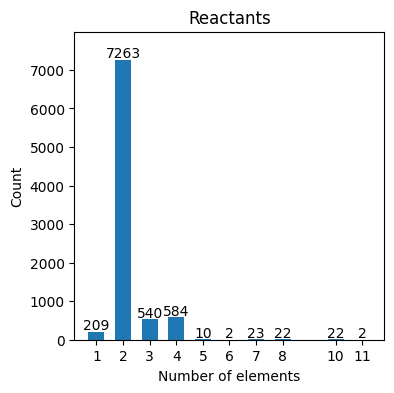

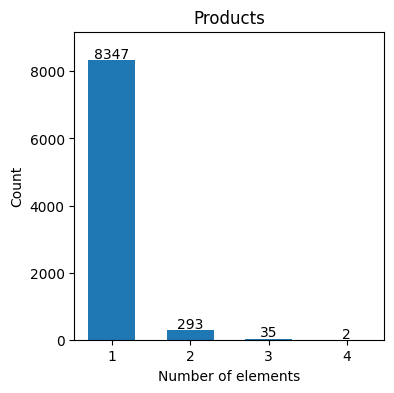

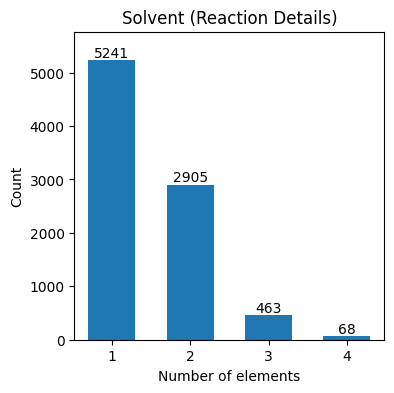

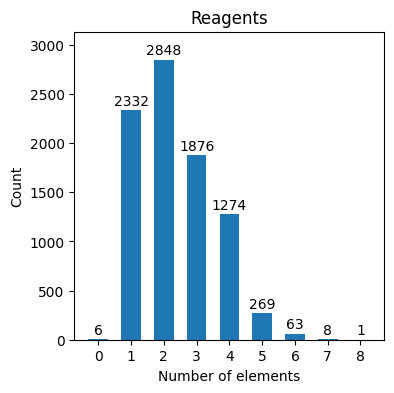

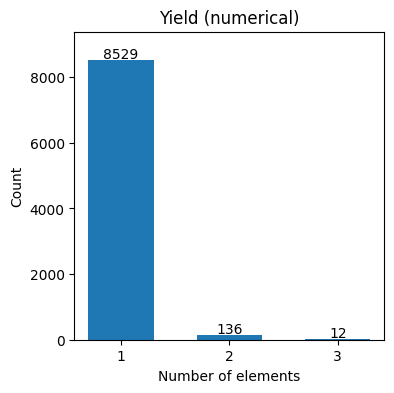

In [ ]:
# Visualize the distribution for each variable
plot_dist(negishi_df)

In [ ]:
# Remove reaction conditions that involve more than 1 product, more than 2 solvents or 4 reagents,
# have no reagents, or with multiple records of yield.
negishi_df = negishi_df[negishi_df["Reactants"].map(len) == 2]
negishi_df = negishi_df[negishi_df["Products"].map(len) == 1]
negishi_df = negishi_df[negishi_df["Solvent (Reaction Details)"].map(len) < 3]
negishi_df = negishi_df[
    (negishi_df["Reagents"].map(len) < 5) & (negishi_df["Reagents"].map(len) > 0)
]
negishi_df = negishi_df[negishi_df["Yield (numerical)"].map(len) == 1]

negishi_df["Yield (numerical)"] = negishi_df["Yield (numerical)"].apply(
    lambda x: float(x[0])
)
overview_df(negishi_df)
negishi_df

Total reactions: 5744
Total contexts: 6367
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6367 entries, 0 to 12003
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Reaction ID                         6367 non-null   object 
 1   Reaction                            6367 non-null   object 
 2   Temperature (Reaction Details) [C]  6367 non-null   object 
 3   Max Temperature                     6367 non-null   int64  
 4   Solvent (Reaction Details)          6367 non-null   object 
 5   Reagents                            6367 non-null   object 
 6   Reactants                           6367 non-null   object 
 7   Products                            6367 non-null   object 
 8   Reactants Smiles                    6367 non-null   object 
 9   Products Smiles                     6367 non-null   object 
 10  Yield (numerical)                   6367 non-null   float64
dtyp

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,29104339,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,25; 25,25,"(tetrahydrofuran,)","(bis(dibenzylideneacetone)-palladium(0), lithi...","[CC1=CC=C(I)C=C1, CC1=CC=C(C=C1)S(=O)(=O)OC1=C...",[CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C...,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C(...,73.0
1,29421049,CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1...,23; 40,40,"(1-methyl-pyrrolidin-2-one, tetrahydrofuran)","(dichloro(1,3-bis(2,6-bis(3-pentyl)phenyl)imid...","[CCC1=CC=CC(CC)=C1Br, CC1=CC(C)=C([Mg]Br)C(C)=C1]",[CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C],CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1,CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C,73.0
2,29590882,IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1>>C...,-20; 25,25,"(tetrahydrofuran,)","(TurboGrignard, bis(dibenzylideneacetone)-pall...","[IC1=CC=CC(=C1)C#N, CCC(=O)C1=CC(Br)=C(F)C=C1]",[CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N],IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1,CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N,73.0
3,29626287,CN1C=C(C=O)C2=CC=CC=C12.CCOC(=O)C1=CC=C(I)C=C1...,25; 25,25,"(tetrahydrofuran,)",(palladium bis(dibenzylideneacetone)palladium(...,"[CN1C=C(C=O)C2=CC=CC=C12, CCOC(=O)C1=CC=C(I)C=C1]",[CCOC(=O)C1=CC=C(C=C1)C1=C(C=O)C2=C(C=CC=C2)N1C],CN1C=C(C=O)C2=CC=CC=C12.CCOC(=O)C1=CC=C(I)C=C1,CCOC(=O)C1=CC=C(C=C1)C1=C(C=O)C2=C(C=CC=C2)N1C,73.0
4,29645183,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,-78; -78 - 20,20,"(tetrahydrofuran,)","(n-butyllithium, tetrakis(triphenylphosphine) ...","[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1, CN(C...",[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(C...,73.0
...,...,...,...,...,...,...,...,...,...,...,...
11998,28467292,CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,45,45,"(tetrahydrofuran, toluene)","([FeCl2(dpbz)2],)","[CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1, BrCC1=C(C=C...",[CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1],CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1,73.0
11999,28527359,ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1>>FC(F...,25 - 55; 65,65,"(tetrahydrofuran,)","((1E,4E)-1,5-diphenylpenta-1,4-dien-3-one pall...","[ClC1=CN=C(Cl)N=C1, FC(F)(F)C1=CC(I)=CC=C1]",[FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1],ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1,FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1,73.0
12000,28765870,ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI>>COC(=O)C...,110; 70,110,"(N,N-dimethyl acetamide, toluene)","(tetrakis(triphenylphosphine) palladium(0), zi...","[ClC1=NC2=CC=CC=C2S1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1],ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1,73.0
12001,28765871,COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI>>COC(=O)C(C...,110; 70,110,"(N,N-dimethyl acetamide, toluene)","(tetrakis(triphenylphosphine) palladium(0), zi...","[COC1=NC(Cl)=NC=C1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC(OC)=CC=N1],COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC(OC)=CC=N1,73.0


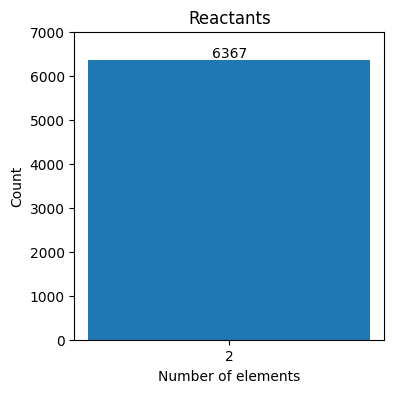

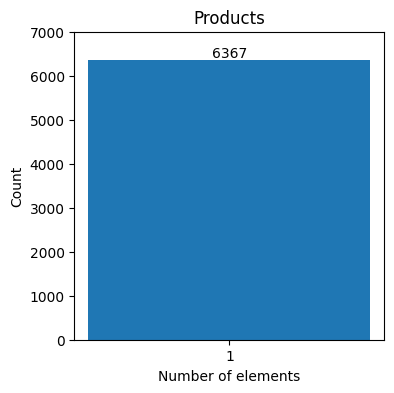

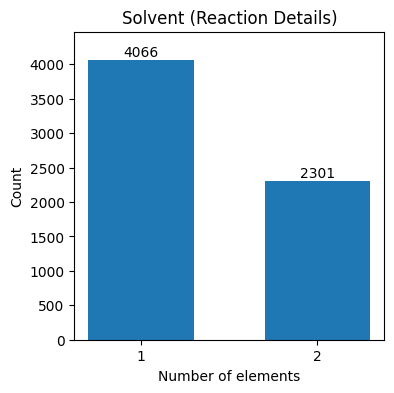

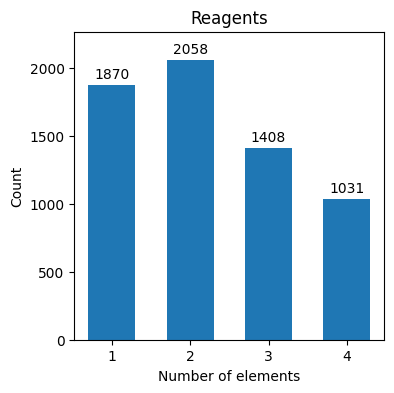

In [ ]:
# Visualize the distribution for each variable
plot_dist(negishi_df)

In [ ]:
# Standardize the labels for reagents and solvents
reagent_name_map_dict = get_name_map_dict(negishi_df, "Reagents")
solvent_name_map_dict = get_name_map_dict(negishi_df, "Solvent (Reaction Details)")
negishi_df = replace_label(negishi_df, reagent_name_map_dict, solvent_name_map_dict)
overview_df(negishi_df)
negishi_df

  4%|▍         | 7/184 [00:13<05:29,  1.86s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > tris-(dibenzylideneacetone)dipalladium(0) is unparsable due to the following being uninterpretable: dipalladium(0) The following was not parseable: palladium(0)

  warnings.warn(
  6%|▌         | 11/184 [00:22<06:27,  2.24s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > dichloro{bis[1-(dicyclohexylphosphanyl)piperidine]}palladium(II) is unparsable due to the following being uninterpretable: palladium(II) The following was not parseable: palladium(II)

  warnings.warn(
  7%|▋         | 13/184 [00:28<06:59,  2.45s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > (1,2-dimethoxyethane)dichloronickel(II) is unparsable due to the fol

Total reactions: 5121
Total contexts: 5459
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5459 entries, 2286 to 14289
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Reaction ID                         5459 non-null   object 
 1   Reaction                            5459 non-null   object 
 2   Temperature (Reaction Details) [C]  5459 non-null   object 
 3   Max Temperature                     5459 non-null   int64  
 4   Solvent (Reaction Details)          5459 non-null   object 
 5   Reagents                            5459 non-null   object 
 6   Reactants                           5459 non-null   object 
 7   Products                            5459 non-null   object 
 8   Reactants Smiles                    5459 non-null   object 
 9   Products Smiles                     5459 non-null   object 
 10  Yield (numerical)                   5459 non-null   float64
d


<ipython-input-30-3a53e6890742>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Solvent (Reaction Details)'] = df['Solvent (Reaction Details)'].apply(lambda x: get_names(x, solvent_name_map_dict))


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
2286,29104339,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,25; 25,25,[tetrahydrofuran],"[bis(dibenzylideneacetone)-palladium(0), lithi...","[CC1=CC=C(I)C=C1, CC1=CC=C(C=C1)S(=O)(=O)OC1=C...",[CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C...,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C(...,73.0
2287,29421049,CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1...,23; 40,40,"[1-methyl-pyrrolidin-2-one, tetrahydrofuran]","[dichloro(1,3-bis(2,6-bis(3-pentyl)phenyl)imid...","[CCC1=CC=CC(CC)=C1Br, CC1=CC(C)=C([Mg]Br)C(C)=C1]",[CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C],CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1,CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C,73.0
2288,29590882,IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1>>C...,-20; 25,25,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[IC1=CC=CC(=C1)C#N, CCC(=O)C1=CC(Br)=C(F)C=C1]",[CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N],IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1,CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N,73.0
2290,29645183,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,-78; -78 - 20,20,[tetrahydrofuran],"[n-butyllithium, tetrakis(triphenylphosphine) ...","[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1, CN(C...",[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(C...,73.0
2291,29662097,O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2.CCOC(=O)C1=C...,-20; -20; 50,50,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2, CCOC(=O)C1...",[CCOC(=O)C1=CC=C(C=C1)C1=CC=CC2=C1OC1=C2C2=C(S...,O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2.CCOC(=O)C1=C...,CCOC(=O)C1=CC=C(C=C1)C1=CC=CC2=C1OC1=C2C2=C(S1...,73.0
...,...,...,...,...,...,...,...,...,...,...,...
14284,28467292,CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,45,45,"[tetrahydrofuran, toluene]",[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1, BrCC1=C(C=C...",[CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1],CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1,73.0
14285,28527359,ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1>>FC(F...,25 - 55; 65,65,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[ClC1=CN=C(Cl)N=C1, FC(F)(F)C1=CC(I)=CC=C1]",[FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1],ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1,FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1,73.0
14286,28765870,ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI>>COC(=O)C...,110; 70,110,"[N,N-dimethyl acetamide, toluene]","[tetrakis(triphenylphosphine) palladium(0), zi...","[ClC1=NC2=CC=CC=C2S1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1],ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1,73.0
14287,28765871,COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI>>COC(=O)C(C...,110; 70,110,"[N,N-dimethyl acetamide, toluene]","[tetrakis(triphenylphosphine) palladium(0), zi...","[COC1=NC(Cl)=NC=C1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC(OC)=CC=N1],COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC(OC)=CC=N1,73.0


In [ ]:
for key in ["Solvent (Reaction Details)", "Reagents"]:
    negishi_df[key] = negishi_df[key].apply(tuple)
negishi_df = negishi_df.drop_duplicates(
    subset=["Reaction ID", "Max Temperature", "Solvent (Reaction Details)", "Reagents"]
)
for key in ["Solvent (Reaction Details)", "Reagents"]:
    negishi_df[key] = negishi_df[key].apply(list)
negishi_df

<ipython-input-103-0f95f288d187>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negishi_df[key] = negishi_df[key].apply(list)


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
2286,29104339,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,25; 25,25,[tetrahydrofuran],"[bis(dibenzylideneacetone)-palladium(0), lithi...","[CC1=CC=C(I)C=C1, CC1=CC=C(C=C1)S(=O)(=O)OC1=C...",[CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C...,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C(...,73.0
2287,29421049,CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1...,23; 40,40,"[1-methyl-pyrrolidin-2-one, tetrahydrofuran]","[dichloro(1,3-bis(2,6-bis(3-pentyl)phenyl)imid...","[CCC1=CC=CC(CC)=C1Br, CC1=CC(C)=C([Mg]Br)C(C)=C1]",[CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C],CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1,CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C,73.0
2288,29590882,IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1>>C...,-20; 25,25,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[IC1=CC=CC(=C1)C#N, CCC(=O)C1=CC(Br)=C(F)C=C1]",[CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N],IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1,CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N,73.0
2290,29645183,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,-78; -78 - 20,20,[tetrahydrofuran],"[n-butyllithium, tetrakis(triphenylphosphine) ...","[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1, CN(C...",[CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(C...,73.0
2291,29662097,O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2.CCOC(=O)C1=C...,-20; -20; 50,50,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2, CCOC(=O)C1...",[CCOC(=O)C1=CC=C(C=C1)C1=CC=CC2=C1OC1=C2C2=C(S...,O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2.CCOC(=O)C1=C...,CCOC(=O)C1=CC=C(C=C1)C1=CC=CC2=C1OC1=C2C2=C(S1...,73.0
...,...,...,...,...,...,...,...,...,...,...,...
14284,28467292,CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,45,45,"[tetrahydrofuran, toluene]",[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1, BrCC1=C(C=C...",[CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1],CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1,73.0
14285,28527359,ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1>>FC(F...,25 - 55; 65,65,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"[ClC1=CN=C(Cl)N=C1, FC(F)(F)C1=CC(I)=CC=C1]",[FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1],ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1,FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1,73.0
14286,28765870,ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI>>COC(=O)C...,110; 70,110,"[N,N-dimethyl acetamide, toluene]","[tetrakis(triphenylphosphine) palladium(0), zi...","[ClC1=NC2=CC=CC=C2S1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1],ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1,73.0
14287,28765871,COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI>>COC(=O)C(C...,110; 70,110,"[N,N-dimethyl acetamide, toluene]","[tetrakis(triphenylphosphine) palladium(0), zi...","[COC1=NC(Cl)=NC=C1, COC(=O)C(C)(C)CI]",[COC(=O)C(C)(C)CC1=NC(OC)=CC=N1],COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC(OC)=CC=N1,73.0


In [ ]:
# Save result
save_path = (
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/negishi/negishi.csv"
)
negishi_df.to_csv(save_path, index=False)

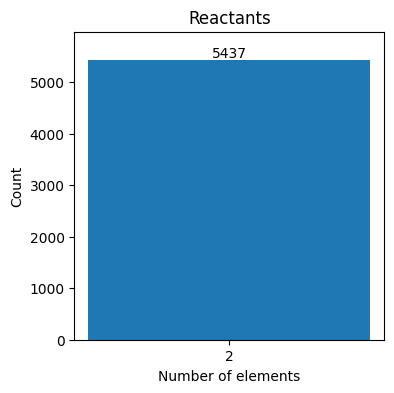

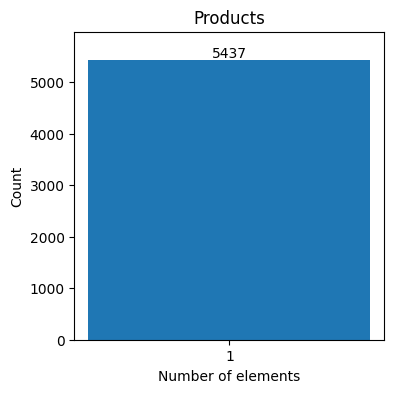

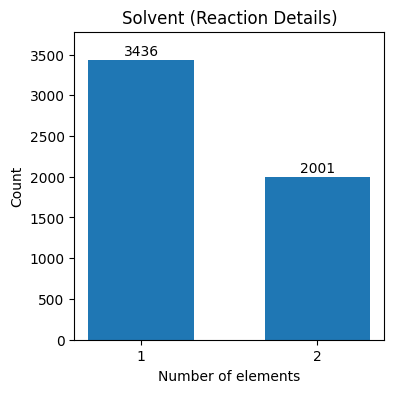

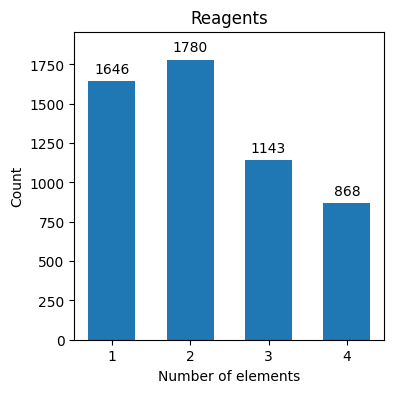

In [ ]:
# Visualize the distribution for each variable
plot_dist(negishi_df)

## buchwald reactions

In [ ]:
# Load data
data_dir = "/content/drive/MyDrive/SCL_Space/data/Reaxys/Raw_data/buchwald/"
buchwald_df = load_data(data_dir)
overview_df(buchwald_df)
buchwald_df

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default sty

Total reactions: 31720
Total contexts: 49182
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49182 entries, 0 to 54282
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Reaction ID                         49182 non-null  object
 1   Reaction                            46733 non-null  object
 2   Temperature (Reaction Details) [C]  40841 non-null  object
 3   Yield (numerical)                   30545 non-null  object
 4   Reagent                             47965 non-null  object
 5   Solvent (Reaction Details)          46553 non-null  object
 6   Catalyst                            3686 non-null   object
dtypes: object(7)
memory usage: 3.0+ MB


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Yield (numerical),Reagent,Solvent (Reaction Details),Catalyst
0,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,50,100,NaN,tetrahydrofuran,NaN
2,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,108,98,NaN,NaN,NaN
3,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,100,98,aliquat 336; potassium carbonate,"N,N-dimethyl-formamide",NaN
4,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,20 - 110,95,copper (I) iodide; potassium carbonate,"N,N-dimethyl-formamide",NaN
5,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,80,95,potassium carbonate,"N,N-dimethyl-formamide",NaN
...,...,...,...,...,...,...,...
54278,61737509,FC(F)(F)C(NC1=CC=C(Cl)C=C1)=COC1=C(Br)C=CC=C1>...,100,NaN,tri-tert-butyl phosphine; palladium diacetate;...,toluene,NaN
54279,61737510,FC(F)(F)C(NC1=CC=C(Br)C=C1)=COC1=C(Br)C=CC=C1>...,100,NaN,tri-tert-butyl phosphine; palladium diacetate;...,toluene,NaN
54280,61737511,FC(F)(F)C(NC1=CC=C(C=C1)C(F)(F)F)=COC1=C(Br)C=...,100,NaN,tri-tert-butyl phosphine; palladium diacetate;...,toluene,NaN
54281,61737512,FC(F)(F)C(NC1=CC=C(C=C1)C#N)=COC1=C(Br)C=CC=C1...,100,NaN,tri-tert-butyl phosphine; palladium diacetate;...,toluene,NaN


In [ ]:
# Preprocess data
buchwald_df = preprocess_data(buchwald_df)
overview_df(buchwald_df)
buchwald_df

Total reactions: 12390
Total contexts: 20992
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20992 entries, 0 to 37810
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Reaction ID                         20992 non-null  object
 1   Reaction                            20992 non-null  object
 2   Temperature (Reaction Details) [C]  20992 non-null  object
 3   Max Temperature                     20992 non-null  int64 
 4   Solvent (Reaction Details)          20992 non-null  object
 5   Reagents                            20992 non-null  object
 6   Reactants                           20992 non-null  object
 7   Products                            20992 non-null  object
 8   Reactants Smiles                    20992 non-null  object
 9   Products Smiles                     20992 non-null  object
 10  Yield (numerical)                   20992 non-null  object
dtypes: int64(

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,50,50,"(tetrahydrofuran,)",(),"[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,"(100,)"
3,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,100,100,"(N,N-dimethyl-formamide,)","(aliquat 336, potassium carbonate)","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,"(98,)"
4,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,20 - 110,110,"(N,N-dimethyl-formamide,)","(copper (I) iodide, potassium carbonate)","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,"(95,)"
5,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,80,80,"(N,N-dimethyl-formamide,)","(potassium carbonate,)","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,"(95,)"
6,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,140,140,"(para-xylene,)","(1,3-bis-(diphenylphosphino)propane, Potassium...","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,"(93,)"
...,...,...,...,...,...,...,...,...,...,...,...
37805,55378803,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,80,80,"(toluene,)","(sodium t-butanolate, trineopentyl phosphine, ...","[CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C, CC(C)(C)...",[CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)...,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)C...,"(2,)"
37806,31615589,FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2>>F...,160,160,"(N,N-dimethyl-formamide,)","(N,N`-dimethylethylenediamine, copper(l) iodid...","[FC1=CC=C(I)C=C1, C1CC(CCO1)C1=CNC2=C1C=CN=C2]",[FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2],FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2,FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2,"(1.9,)"
37808,37131219,CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC>>CCOC(=O)C1=N...,90,90,"(1,4-dioxane,)","(4,5-bis(diphenylphosphino)-9,9-dimethylxanthe...","[CCOC(=O)C1=NC(C)=C(Br)C=C1, CCNCC]",[CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC],CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC,CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC,"(1,)"
37809,50072174,ClC1=NC2=C(C=CN2)C(Br)=C1.C[C@@H]1CC2=NC=NC(C3...,80,80,"(1,4-dioxane,)","((2-dicyclohexylphosphino-2’,6’-diisopropoxy-1...","[ClC1=NC2=C(C=CN2)C(Br)=C1, C[C@@H]1CC2=NC=NC(...",[C[C@@H]1CC2=NC=NC(C3CCCN(C3)S(C)(=O)=O)=C2CN1...,ClC1=NC2=C(C=CN2)C(Br)=C1.C[C@@H]1CC2=NC=NC(C3...,C[C@@H]1CC2=NC=NC(C3CCCN(C3)S(C)(=O)=O)=C2CN1C...,"(1,)"


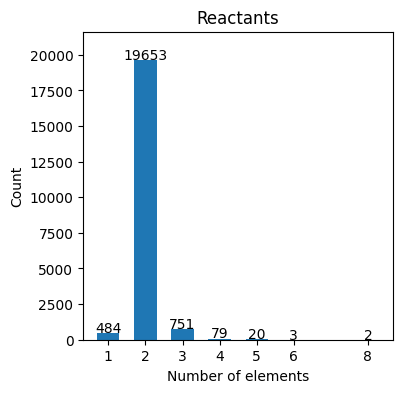

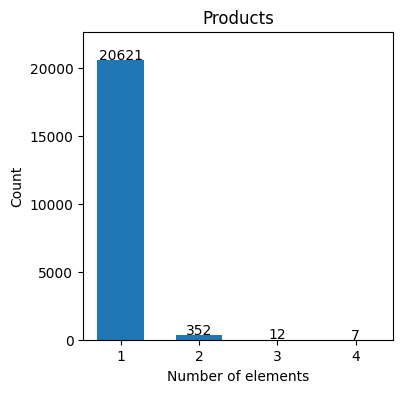

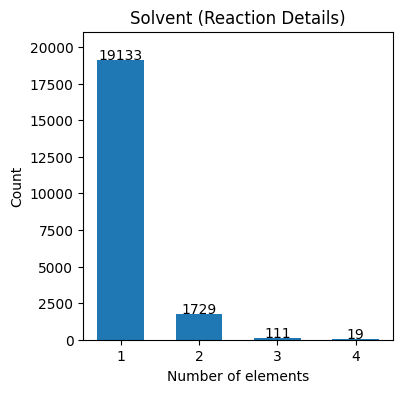

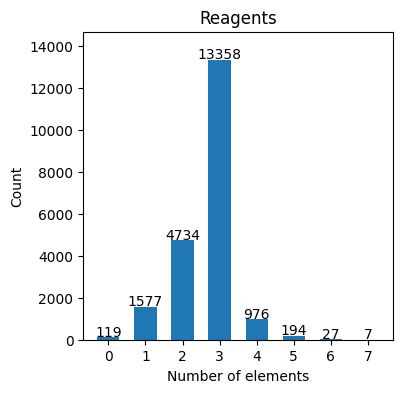

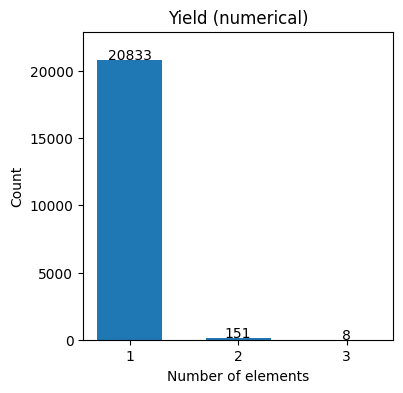

In [ ]:
# Visualize the distribution for each variable
plot_dist(buchwald_df)

In [ ]:
# Remove reaction conditions that involve more than 1 product, more than 2 solvents or 4 reagents,
# have no reagents, or with multiple records of yield.
buchwald_df = buchwald_df[buchwald_df["Reactants"].map(len) == 2]
buchwald_df = buchwald_df[buchwald_df["Products"].map(len) == 1]
buchwald_df = buchwald_df[buchwald_df["Solvent (Reaction Details)"].map(len) < 3]
buchwald_df = buchwald_df[
    (buchwald_df["Reagents"].map(len) < 5) & (buchwald_df["Reagents"].map(len) > 0)
]
buchwald_df = buchwald_df[buchwald_df["Yield (numerical)"].map(len) == 1]

buchwald_df["Yield (numerical)"] = buchwald_df["Yield (numerical)"].apply(
    lambda x: float(x[0])
)
overview_df(buchwald_df)
buchwald_df

Total reactions: 10917
Total contexts: 19142
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19142 entries, 3 to 37810
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Reaction ID                         19142 non-null  object 
 1   Reaction                            19142 non-null  object 
 2   Temperature (Reaction Details) [C]  19142 non-null  object 
 3   Max Temperature                     19142 non-null  int64  
 4   Solvent (Reaction Details)          19142 non-null  object 
 5   Reagents                            19142 non-null  object 
 6   Reactants                           19142 non-null  object 
 7   Products                            19142 non-null  object 
 8   Reactants Smiles                    19142 non-null  object 
 9   Products Smiles                     19142 non-null  object 
 10  Yield (numerical)                   19142 non-null  float64
d

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
3,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,100,100,"(N,N-dimethyl-formamide,)","(aliquat 336, potassium carbonate)","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,98.0
4,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,20 - 110,110,"(N,N-dimethyl-formamide,)","(copper (I) iodide, potassium carbonate)","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
5,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,80,80,"(N,N-dimethyl-formamide,)","(potassium carbonate,)","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
6,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,140,140,"(para-xylene,)","(1,3-bis-(diphenylphosphino)propane, Potassium...","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,93.0
7,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,80,80,"(1-methyl-pyrrolidin-2-one,)","(lithium trifluoromethanesulphonate,)","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,93.0
...,...,...,...,...,...,...,...,...,...,...,...
37805,55378803,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,80,80,"(toluene,)","(sodium t-butanolate, trineopentyl phosphine, ...","[CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C, CC(C)(C)...",[CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)...,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)C...,2.0
37806,31615589,FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2>>F...,160,160,"(N,N-dimethyl-formamide,)","(N,N`-dimethylethylenediamine, copper(l) iodid...","[FC1=CC=C(I)C=C1, C1CC(CCO1)C1=CNC2=C1C=CN=C2]",[FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2],FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2,FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2,1.9
37808,37131219,CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC>>CCOC(=O)C1=N...,90,90,"(1,4-dioxane,)","(4,5-bis(diphenylphosphino)-9,9-dimethylxanthe...","[CCOC(=O)C1=NC(C)=C(Br)C=C1, CCNCC]",[CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC],CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC,CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC,1.0
37809,50072174,ClC1=NC2=C(C=CN2)C(Br)=C1.C[C@@H]1CC2=NC=NC(C3...,80,80,"(1,4-dioxane,)","((2-dicyclohexylphosphino-2’,6’-diisopropoxy-1...","[ClC1=NC2=C(C=CN2)C(Br)=C1, C[C@@H]1CC2=NC=NC(...",[C[C@@H]1CC2=NC=NC(C3CCCN(C3)S(C)(=O)=O)=C2CN1...,ClC1=NC2=C(C=CN2)C(Br)=C1.C[C@@H]1CC2=NC=NC(C3...,C[C@@H]1CC2=NC=NC(C3CCCN(C3)S(C)(=O)=O)=C2CN1C...,1.0


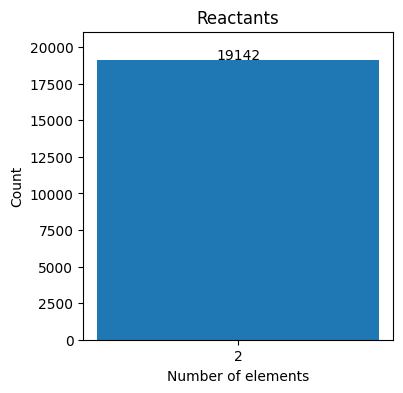

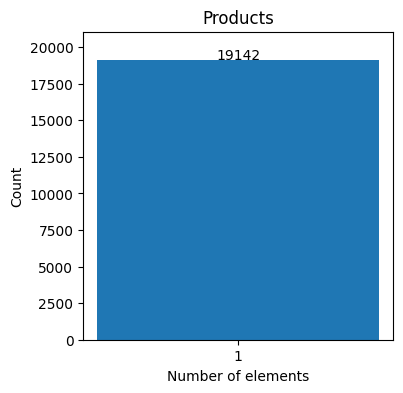

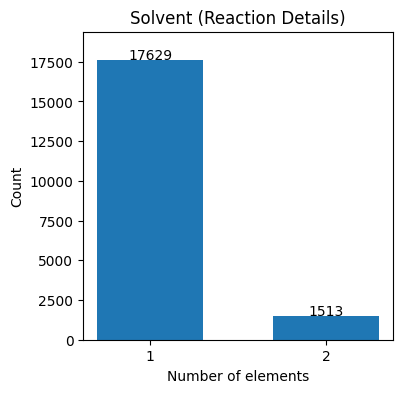

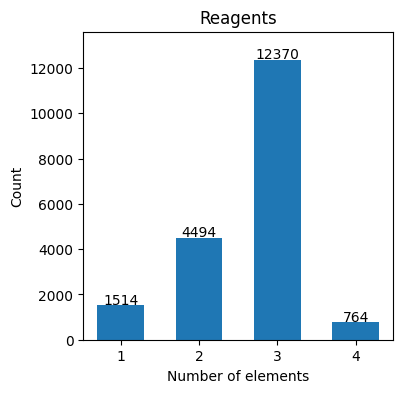

In [ ]:
# Visualize the distribution for each variable
plot_dist(buchwald_df)

In [ ]:
# Standardize the labels for reagents and solvents
reagent_name_map_dict = get_name_map_dict(buchwald_df, "Reagents")
solvent_name_map_dict = get_name_map_dict(buchwald_df, "Solvent (Reaction Details)")
buchwald_df = replace_label(buchwald_df, reagent_name_map_dict, solvent_name_map_dict)
overview_df(buchwald_df)
buchwald_df

  1%|          | 3/414 [00:05<12:55,  1.89s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > tris-(dibenzylideneacetone)dipalladium(0) is unparsable due to the following being uninterpretable: dipalladium(0) The following was not parseable: palladium(0)

  warnings.warn(
  2%|▏         | 8/414 [00:18<15:31,  2.29s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > copper(l) iodide is unparsable due to the following being uninterpretable: (l) iodide The following was not parseable: l) iodide

  warnings.warn(
  2%|▏         | 10/414 [00:22<15:09,  2.25s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > XPhos is unparsable due to the following being uninterpretable: XPhos The following was not parseable: XPhos

  warnings.war

Total reactions: 10276
Total contexts: 16145
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16145 entries, 4 to 37810
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Reaction ID                         16145 non-null  object 
 1   Reaction                            16145 non-null  object 
 2   Temperature (Reaction Details) [C]  16145 non-null  object 
 3   Max Temperature                     16145 non-null  int64  
 4   Solvent (Reaction Details)          16145 non-null  object 
 5   Reagents                            16145 non-null  object 
 6   Reactants                           16145 non-null  object 
 7   Products                            16145 non-null  object 
 8   Reactants Smiles                    16145 non-null  object 
 9   Products Smiles                     16145 non-null  object 
 10  Yield (numerical)                   16145 non-null  float64
d

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
4,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,20 - 110,110,"[N,N-dimethyl-formamide]","[copper (I) iodide, potassium carbonate]","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
5,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,80,80,"[N,N-dimethyl-formamide]",[potassium carbonate],"[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
8,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,120,120,[neat (no solvent)],[potassium carbonate],"[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,92.0
9,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,130,130,"[N,N-dimethyl-formamide]","[copper(l) iodide, caesium carbonate, copper (...","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,91.0
12,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,100,100,[iso-butanol],"[copper(l) iodide, potassium carbonate]","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,84.5
...,...,...,...,...,...,...,...,...,...,...,...
37804,54035287,CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCCC...,100,100,[toluene],"[1,1'-bis-(diphenylphosphino)ferrocene, sodium...",[CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCC...,[CCCCCCC1=CC=C(S1)C1=CC(NC2=C(Br)C=C(NC3=C(C=C...,CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCCC...,CCCCCCC1=CC=C(S1)C1=CC(NC2=C(Br)C=C(NC3=C(C=CC...,2.0
37805,55378803,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,80,80,[toluene],"[sodium t-butanolate, trineopentyl phosphine, ...","[CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C, CC(C)(C)...",[CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)...,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)C...,2.0
37806,31615589,FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2>>F...,160,160,"[N,N-dimethyl-formamide]","[N,N`-dimethylethylenediamine, copper(l) iodid...","[FC1=CC=C(I)C=C1, C1CC(CCO1)C1=CNC2=C1C=CN=C2]",[FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2],FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2,FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2,1.9
37808,37131219,CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC>>CCOC(=O)C1=N...,90,90,"[1,4-dioxane]","[4,5-bis(diphenylphosphino)-9,9-dimethylxanthe...","[CCOC(=O)C1=NC(C)=C(Br)C=C1, CCNCC]",[CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC],CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC,CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC,1.0


In [ ]:
for key in ["Solvent (Reaction Details)", "Reagents"]:
    buchwald_df[key] = buchwald_df[key].apply(tuple)
buchwald_df = buchwald_df.drop_duplicates(
    subset=["Reaction ID", "Max Temperature", "Solvent (Reaction Details)", "Reagents"]
)
for key in ["Solvent (Reaction Details)", "Reagents"]:
    buchwald_df[key] = buchwald_df[key].apply(list)
buchwald_df

<ipython-input-21-6821de3b5f4d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buchwald_df[key] = buchwald_df[key].apply(list)


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
4,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,20 - 110,110,"[N,N-dimethyl-formamide]","[copper (I) iodide, potassium carbonate]","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
5,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,80,80,"[N,N-dimethyl-formamide]",[potassium carbonate],"[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
8,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,120,120,[neat (no solvent)],[potassium carbonate],"[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,92.0
9,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,130,130,"[N,N-dimethyl-formamide]","[copper(l) iodide, caesium carbonate, copper (...","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,91.0
12,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,100,100,[iso-butanol],"[copper(l) iodide, potassium carbonate]","[C1CCNC1, ClC1=CC=C(C=C1)N(=O)=O]",[O=N(=O)C1=CC=C(C=C1)N1CCCC1],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,84.5
...,...,...,...,...,...,...,...,...,...,...,...
37804,54035287,CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCCC...,100,100,[toluene],"[1,1'-bis-(diphenylphosphino)ferrocene, sodium...",[CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCC...,[CCCCCCC1=CC=C(S1)C1=CC(NC2=C(Br)C=C(NC3=C(C=C...,CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCCC...,CCCCCCC1=CC=C(S1)C1=CC(NC2=C(Br)C=C(NC3=C(C=CC...,2.0
37805,55378803,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,80,80,[toluene],"[sodium t-butanolate, trineopentyl phosphine, ...","[CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C, CC(C)(C)...",[CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)...,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)C...,2.0
37806,31615589,FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2>>F...,160,160,"[N,N-dimethyl-formamide]","[N,N`-dimethylethylenediamine, copper(l) iodid...","[FC1=CC=C(I)C=C1, C1CC(CCO1)C1=CNC2=C1C=CN=C2]",[FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2],FC1=CC=C(I)C=C1.C1CC(CCO1)C1=CNC2=C1C=CN=C2,FC1=CC=C(C=C1)N1C=C(C2CCOCC2)C2=C1C=NC=C2,1.9
37808,37131219,CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC>>CCOC(=O)C1=N...,90,90,"[1,4-dioxane]","[4,5-bis(diphenylphosphino)-9,9-dimethylxanthe...","[CCOC(=O)C1=NC(C)=C(Br)C=C1, CCNCC]",[CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC],CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC,CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC,1.0


In [ ]:
# Save result
save_path = "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/buchwald/buchwald.csv"
buchwald_df.to_csv(save_path, index=False)

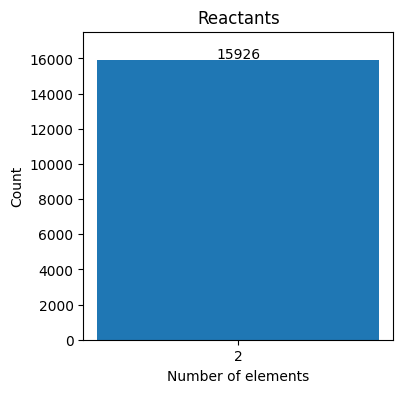

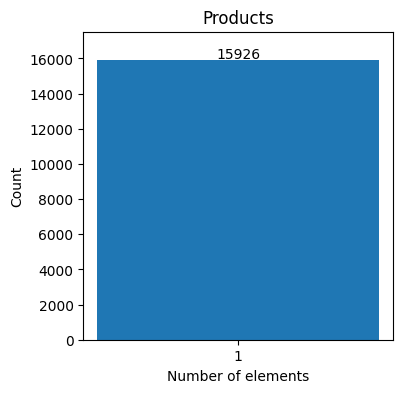

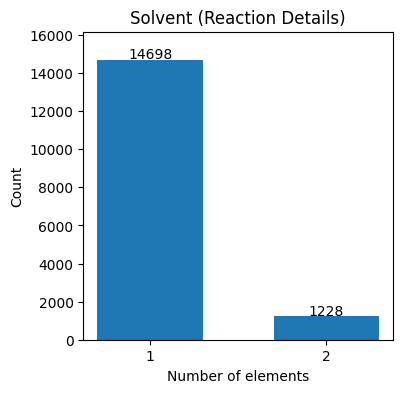

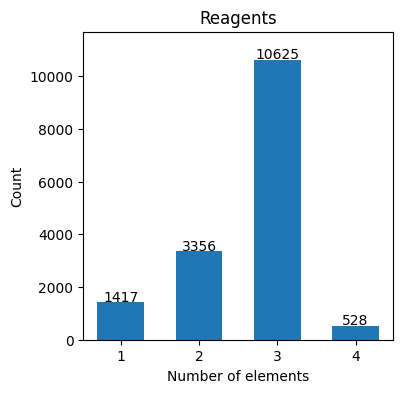

In [ ]:
# Visualize the distribution for each variable
plot_dist(buchwald_df)

## suzuki reactions

In [ ]:
# Load data
data_dir = "/content/drive/MyDrive/SCL_Space/data/Reaxys/Raw_data/suzuki/"
suzuki_df = load_data(data_dir)
overview_df(suzuki_df)
suzuki_df

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default sty

Total reactions: 207647
Total contexts: 293083
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293083 entries, 0 to 315697
Data columns (total 7 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Reaction ID                         293083 non-null  object
 1   Reaction                            279624 non-null  object
 2   Temperature (Reaction Details) [C]  239784 non-null  object
 3   Yield (numerical)                   186814 non-null  object
 4   Reagent                             288737 non-null  object
 5   Solvent (Reaction Details)          279609 non-null  object
 6   Catalyst                            33026 non-null   object
dtypes: object(7)
memory usage: 17.9+ MB


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Yield (numerical),Reagent,Solvent (Reaction Details),Catalyst
0,32433079,CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,80,99,"dichloro(1,1'-bis(diphenylphosphanyl)ferrocene...","1,2-dimethoxyethane; water",NaN
2,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,100,99,tetrakis(triphenylphosphine) palladium(0); sod...,"water; N,N-dimethyl-formamide",NaN
3,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,80,94,"N,N-diisopropyl-2-(4-methylstyryl)-benzamide; ...","1,4-dioxane",NaN
4,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,80,NaN,bis-triphenylphosphine-palladium(II) chloride;...,dimethyl sulfoxide,NaN
5,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,NaN,NaN,tetrakis(triphenylphosphine) palladium(0); pot...,"1,4-dioxane; water",NaN
...,...,...,...,...,...,...,...
315692,64163303,>>CC(=O)C1=CC=C(O1)C1=CC=CC=C1OC1=CC=CC=C1,100,NaN,tetrakis(triphenylphosphine) palladium(0); cae...,water; toluene,NaN
315694,64169782,OB(O)C1=COC=C1.BrC1=CC=C(C=C1)C1=CC=CC=C1>>O1C...,25,NaN,palladium diacetate; potassium carbonate; ruphos,"1,4-dioxane; water",NaN
315695,64169783,OB(O)C1=COC=C1.ClC1=CC=C(C=C1)C1=CC=CC=C1>>O1C...,25,NaN,palladium diacetate; potassium carbonate; ruphos,"1,4-dioxane; water",NaN
315696,64169784,CC1=CC=CC(C)=C1B(O)O.ClC1=CC=C(C=C1)C1=CC=CC=C...,25,NaN,palladium diacetate; potassium carbonate; ruphos,"1,4-dioxane; water",NaN


In [ ]:
# Preprocess data
suzuki_df = preprocess_data(suzuki_df)
overview_df(suzuki_df)
suzuki_df

Total reactions: 91716
Total contexts: 127774
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127774 entries, 0 to 228110
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Reaction ID                         127774 non-null  object
 1   Reaction                            127774 non-null  object
 2   Temperature (Reaction Details) [C]  127774 non-null  object
 3   Max Temperature                     127774 non-null  int64 
 4   Solvent (Reaction Details)          127774 non-null  object
 5   Reagents                            127774 non-null  object
 6   Reactants                           127774 non-null  object
 7   Products                            127774 non-null  object
 8   Reactants Smiles                    127774 non-null  object
 9   Products Smiles                     127774 non-null  object
 10  Yield (numerical)                   127774 non-null  objec

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,32433079,CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,80,80,"(1,2-dimethoxyethane, water)","(dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1, COC1...",[COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1],CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1,"(99,)"
2,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,100,100,"(N,N-dimethyl-formamide, water)","(sodium carbonate, tetrakis(triphenylphosphine...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,"(99,)"
3,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,80,80,"(1,4-dioxane,)","(N,N-diisopropyl-2-(4-methylstyryl)-benzamide,...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,"(94,)"
8,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,"(water,)","(potassium carbonate,)","[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,"(99,)"
9,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,"(ethanol, water)","(potassium carbonate,)","[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,"(85,)"
...,...,...,...,...,...,...,...,...,...,...,...
228083,47959922,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,90,90,"(N,N-dimethyl-formamide,)","(dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[COC1=CC(C)=C2N=C(Br)SC2=C1, CCOCC1=NC2=CC(C)=...",[CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)...,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)=...,"(0.996,)"
228084,38601118,CC1=C(Br)C=NC(=C1)N1CCOCC1.ClC1=CC=C(C=C1)N1C=...,0; 160,160,"(1,4-dioxane, n-heptane, tetrahydrofuran, water)","(Triisopropyl borate, lithium diisopropyl amid...","[CC1=C(Br)C=NC(=C1)N1CCOCC1, ClC1=CC=C(C=C1)N1...","[OC(=O)C(F)(F)F, CC1=CC(=NC=C1C1=CC2=CC=NC=C2N...",CC1=C(Br)C=NC(=C1)N1CCOCC1.ClC1=CC=C(C=C1)N1C=...,OC(=O)C(F)(F)F.CC1=CC(=NC=C1C1=CC2=CC=NC=C2N1C...,"(0.95,)"
228099,59754144,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,105,105,"(1,4-dioxane, lithium hydroxide monohydrate)","(palladium (II) [1,1'-bis(diphenylphosphanyl)f...",[CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=...,[CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C...,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C2...,"(0.78,)"
228108,43272448,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,100,100,"(1,4-dioxane, water)",(dichloro bis((p-dimethylaminophenyl)-ϖ-di-ter...,"[CC1=NC=C(I)N1, [H][C@@]1(CNC(=O)C1)[C@@H](C)O...",[C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1C...,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1CC...,"(0.6,)"


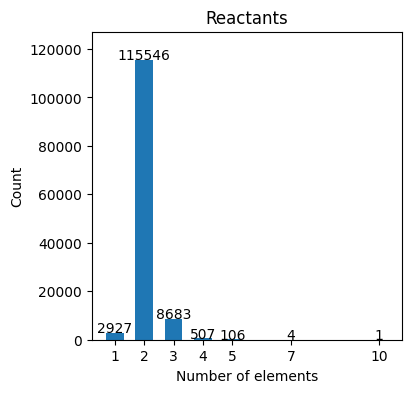

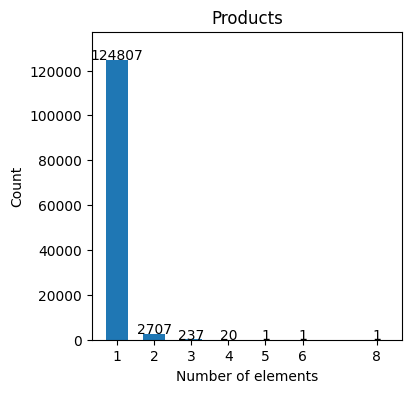

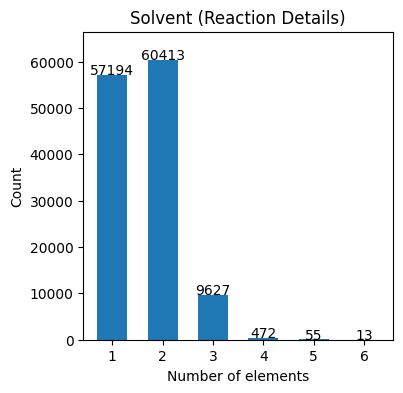

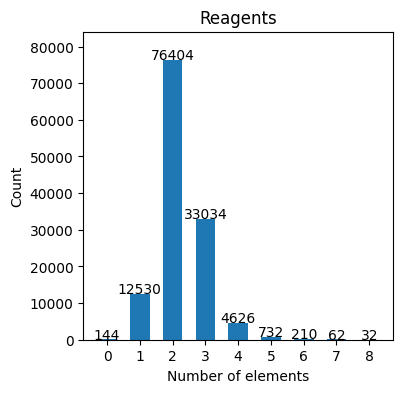

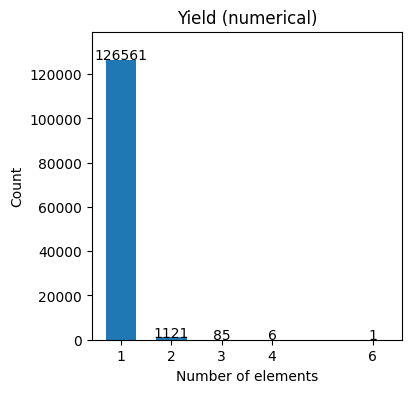

In [ ]:
# Visualize the distribution for each variable
plot_dist(suzuki_df)

In [ ]:
# Remove reaction conditions that involve more than 1 product, more than 2 solvents or 4 reagents,
# have no reagents, or with multiple records of yield.
suzuki_df = suzuki_df[suzuki_df["Reactants"].map(len) == 2]
suzuki_df = suzuki_df[suzuki_df["Products"].map(len) == 1]
suzuki_df = suzuki_df[suzuki_df["Solvent (Reaction Details)"].map(len) < 3]
suzuki_df = suzuki_df[
    (suzuki_df["Reagents"].map(len) < 5) & (suzuki_df["Reagents"].map(len) > 0)
]
suzuki_df = suzuki_df[suzuki_df["Yield (numerical)"].map(len) == 1]

suzuki_df["Yield (numerical)"] = suzuki_df["Yield (numerical)"].apply(
    lambda x: float(x[0])
)
overview_df(suzuki_df)
suzuki_df

Total reactions: 73169
Total contexts: 104162
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104162 entries, 0 to 228110
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Reaction ID                         104162 non-null  object 
 1   Reaction                            104162 non-null  object 
 2   Temperature (Reaction Details) [C]  104162 non-null  object 
 3   Max Temperature                     104162 non-null  int64  
 4   Solvent (Reaction Details)          104162 non-null  object 
 5   Reagents                            104162 non-null  object 
 6   Reactants                           104162 non-null  object 
 7   Products                            104162 non-null  object 
 8   Reactants Smiles                    104162 non-null  object 
 9   Products Smiles                     104162 non-null  object 
 10  Yield (numerical)                   104162 non

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,32433079,CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,80,80,"(1,2-dimethoxyethane, water)","(dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1, COC1...",[COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1],CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1,99.000
2,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,100,100,"(N,N-dimethyl-formamide, water)","(sodium carbonate, tetrakis(triphenylphosphine...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,99.000
3,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,80,80,"(1,4-dioxane,)","(N,N-diisopropyl-2-(4-methylstyryl)-benzamide,...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,94.000
8,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,"(water,)","(potassium carbonate,)","[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,99.000
9,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,"(ethanol, water)","(potassium carbonate,)","[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,85.000
...,...,...,...,...,...,...,...,...,...,...,...
228080,58809272,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,90,90,"(1,4-dioxane,)","((1,1'-bis(diphenylphosphino)ferrocene)palladi...","[CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O, CC(C)[C@@H]1C...",[CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C2...,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C2C...,1.000
228083,47959922,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,90,90,"(N,N-dimethyl-formamide,)","(dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[COC1=CC(C)=C2N=C(Br)SC2=C1, CCOCC1=NC2=CC(C)=...",[CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)...,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)=...,0.996
228099,59754144,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,105,105,"(1,4-dioxane, lithium hydroxide monohydrate)","(palladium (II) [1,1'-bis(diphenylphosphanyl)f...",[CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=...,[CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C...,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C2...,0.780
228108,43272448,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,100,100,"(1,4-dioxane, water)",(dichloro bis((p-dimethylaminophenyl)-ϖ-di-ter...,"[CC1=NC=C(I)N1, [H][C@@]1(CNC(=O)C1)[C@@H](C)O...",[C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1C...,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1CC...,0.600


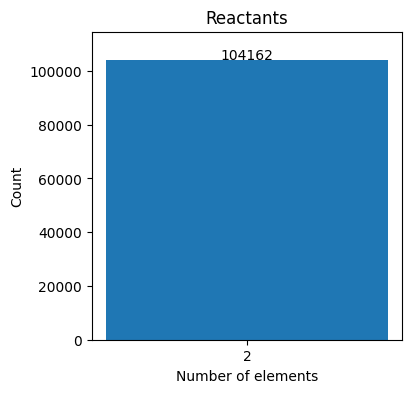

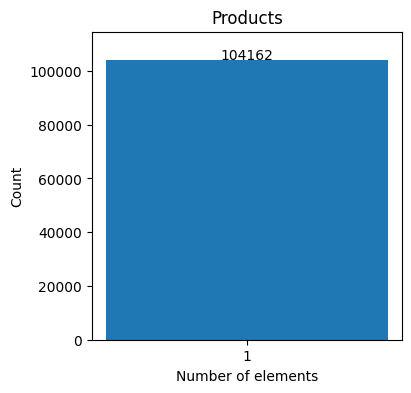

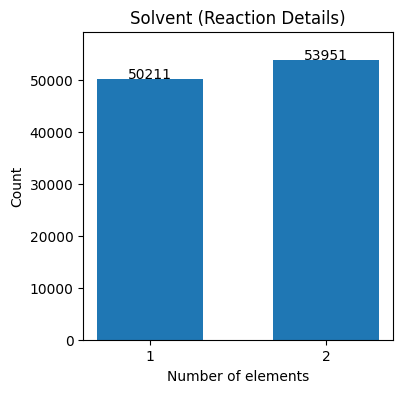

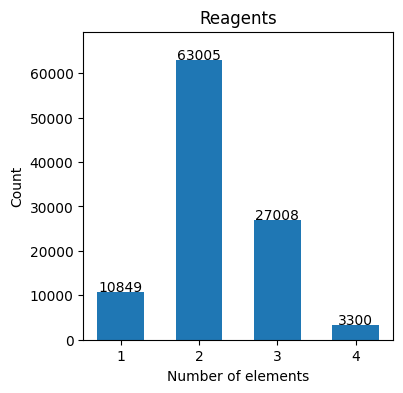

In [ ]:
# Visualize the distribution for each variable
plot_dist(suzuki_df)

In [ ]:
# Standardize the labels for reagents and solvents
reagent_name_map_dict = get_name_map_dict(suzuki_df, "Reagents")
solvent_name_map_dict = get_name_map_dict(suzuki_df, "Solvent (Reaction Details)")
suzuki_df = replace_label(suzuki_df, reagent_name_map_dict, solvent_name_map_dict)
overview_df(suzuki_df)
suzuki_df

  0%|          | 6/1235 [00:15<51:28,  2.51s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > (1,1'-bis(diphenylphosphino)ferrocene)palladium(II) dichloride is unparsable due to the following being uninterpretable: palladium(II) dichloride The following was not parseable: palladium(II) dichloride

  warnings.warn(
  1%|          | 8/1235 [00:20<48:22,  2.37s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > dichloro(1,1'-bis(diphenylphosphanyl)ferrocene)palladium(II)*CH2Cl2 is unparsable due to the following being uninterpretable: palladium(II)*CH2Cl2 The following was not parseable: palladium(II)*CH2Cl2

  warnings.warn(
  1%|          | 9/1235 [00:23<50:35,  2.48s/it]/usr/local/lib/python3.10/dist-packages/py2opsin/py2opsin.py:145: RuntimeWarning: OPSIN raised the following error(s) while parsing:
 > tris-(d

Total reactions: 71344
Total contexts: 96558
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96558 entries, 0 to 228110
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Reaction ID                         96558 non-null  object 
 1   Reaction                            96558 non-null  object 
 2   Temperature (Reaction Details) [C]  96558 non-null  object 
 3   Max Temperature                     96558 non-null  int64  
 4   Solvent (Reaction Details)          96558 non-null  object 
 5   Reagents                            96558 non-null  object 
 6   Reactants                           96558 non-null  object 
 7   Products                            96558 non-null  object 
 8   Reactants Smiles                    96558 non-null  object 
 9   Products Smiles                     96558 non-null  object 
 10  Yield (numerical)                   96558 non-null  float64


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,32433079,CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,80,80,"[1,2-dimethoxyethane, water]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1, COC1...",[COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1],CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1,99.000
2,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,100,100,"[N,N-dimethyl-formamide, water]","[sodium carbonate, tetrakis(triphenylphosphine...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,99.000
3,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,80,80,"[1,4-dioxane]","[N,N-diisopropyl-2-(4-methylstyryl)-benzamide,...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,94.000
8,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,[water],[potassium carbonate],"[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,99.000
9,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,"[ethanol, water]",[potassium carbonate],"[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,85.000
...,...,...,...,...,...,...,...,...,...,...,...
228080,58809272,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,90,90,"[1,4-dioxane]","[(1,1'-bis(diphenylphosphino)ferrocene)palladi...","[CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O, CC(C)[C@@H]1C...",[CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C2...,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C2C...,1.000
228083,47959922,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,90,90,"[N,N-dimethyl-formamide]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[COC1=CC(C)=C2N=C(Br)SC2=C1, CCOCC1=NC2=CC(C)=...",[CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)...,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)=...,0.996
228099,59754144,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,105,105,"[1,4-dioxane, lithium hydroxide monohydrate]","[palladium (II) [1,1'-bis(diphenylphosphanyl)f...",[CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=...,[CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C...,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C2...,0.780
228108,43272448,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,100,100,"[1,4-dioxane, water]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[CC1=NC=C(I)N1, [H][C@@]1(CNC(=O)C1)[C@@H](C)O...",[C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1C...,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1CC...,0.600


In [ ]:
for key in ["Solvent (Reaction Details)", "Reagents"]:
    suzuki_df[key] = suzuki_df[key].apply(tuple)
suzuki_df = suzuki_df.drop_duplicates(
    subset=["Reaction ID", "Max Temperature", "Solvent (Reaction Details)", "Reagents"]
)
for key in ["Solvent (Reaction Details)", "Reagents"]:
    suzuki_df[key] = suzuki_df[key].apply(list)
suzuki_df

<ipython-input-31-ad913efdf32f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suzuki_df[key] = suzuki_df[key].apply(list)


,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,32433079,CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,80,80,"[1,2-dimethoxyethane, water]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1, COC1...",[COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1],CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1,99.000
2,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,100,100,"[N,N-dimethyl-formamide, water]","[sodium carbonate, tetrakis(triphenylphosphine...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,99.000
3,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,80,80,"[1,4-dioxane]","[N,N-diisopropyl-2-(4-methylstyryl)-benzamide,...","[COC1=CC=C(C=O)C(Br)=C1, OB(O)C1=CC=CC=C1]",[COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,94.000
8,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,[water],[potassium carbonate],"[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,99.000
9,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,"[ethanol, water]",[potassium carbonate],"[BrC1=CN=CC=C1, CC1(C)OB(OC1(C)C)C1=CC=CC=C1]",[C1=CC=C(C=C1)C1=CC=CN=C1],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,85.000
...,...,...,...,...,...,...,...,...,...,...,...
228080,58809272,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,90,90,"[1,4-dioxane]","[(1,1'-bis(diphenylphosphino)ferrocene)palladi...","[CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O, CC(C)[C@@H]1C...",[CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C2...,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C2C...,1.000
228083,47959922,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,90,90,"[N,N-dimethyl-formamide]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[COC1=CC(C)=C2N=C(Br)SC2=C1, CCOCC1=NC2=CC(C)=...",[CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)...,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)=...,0.996
228099,59754144,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,105,105,"[1,4-dioxane, lithium hydroxide monohydrate]","[palladium (II) [1,1'-bis(diphenylphosphanyl)f...",[CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=...,[CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C...,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C2...,0.780
228108,43272448,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,100,100,"[1,4-dioxane, water]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","[CC1=NC=C(I)N1, [H][C@@]1(CNC(=O)C1)[C@@H](C)O...",[C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1C...,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1CC...,0.600


In [ ]:
# Save result
save_path = (
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/suzuki/suzuki.csv"
)
suzuki_df.to_csv(save_path, index=False)

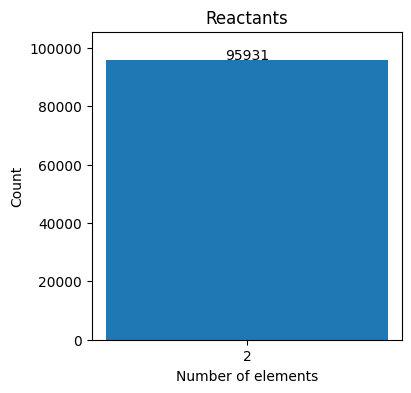

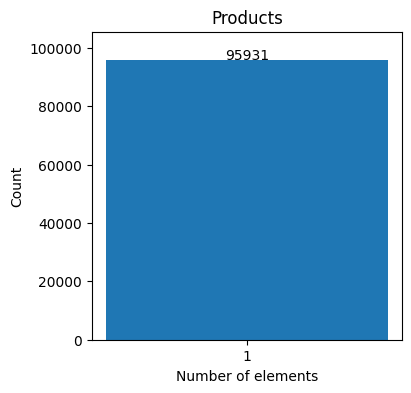

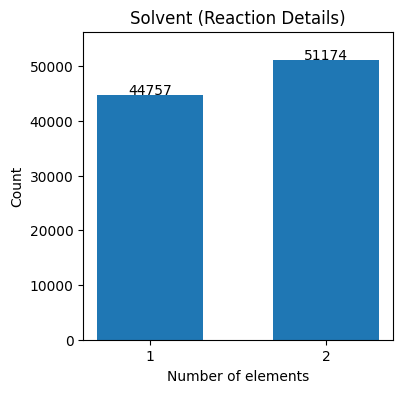

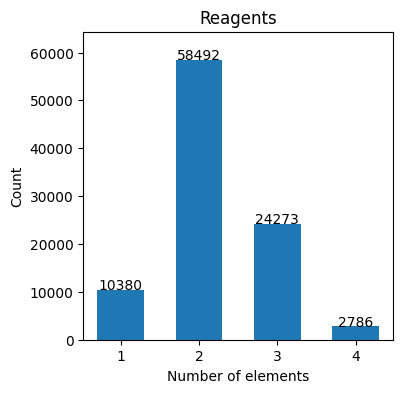

In [ ]:
# Visualize the distribution for each variable
plot_dist(suzuki_df)

# Create features file

In [ ]:
def int_to_binary(integer_value, num_bits=8):
    try:
        # Use the 'b' format specifier to convert the integer to a binary string
        binary_string = format(int(integer_value), f"0{num_bits}b")
        binary_array = [int(bit) for bit in binary_string]
    except:
        print(integer_value)
    return binary_array

## negishi reactions

In [ ]:
data_path = (
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/negishi/negishi.csv"
)
negishi_df = pd.read_csv(data_path)
negishi_df["Reagents"] = negishi_df["Reagents"].apply(ast.literal_eval)
negishi_df["Solvent (Reaction Details)"] = negishi_df[
    "Solvent (Reaction Details)"
].apply(ast.literal_eval)
negishi_df = negishi_df[
    (negishi_df["Max Temperature"] >= 20) & (negishi_df["Max Temperature"] <= 150)
]
negishi_df = negishi_df.reset_index(drop=True)
negishi_df

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,29104339,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,25; 25,25,[tetrahydrofuran],"[bis(dibenzylideneacetone)-palladium(0), lithi...","['CC1=CC=C(I)C=C1', 'CC1=CC=C(C=C1)S(=O)(=O)OC...",['CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)...,CC1=CC=C(I)C=C1.CC1=CC=C(C=C1)S(=O)(=O)OC1=C(B...,CC1=CC=C(C=C1)C1=C(OS(=O)(=O)C2=CC=C(C)C=C2)C(...,73.0
1,29421049,CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1...,23; 40,40,"[1-methyl-pyrrolidin-2-one, tetrahydrofuran]","[dichloro(1,3-bis(2,6-bis(3-pentyl)phenyl)imid...","['CCC1=CC=CC(CC)=C1Br', 'CC1=CC(C)=C([Mg]Br)C(...",['CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C'],CCC1=CC=CC(CC)=C1Br.CC1=CC(C)=C([Mg]Br)C(C)=C1,CCC1=CC=CC(CC)=C1C1=C(C)C=C(C)C=C1C,73.0
2,29590882,IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1>>C...,-20; 25,25,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"['IC1=CC=CC(=C1)C#N', 'CCC(=O)C1=CC(Br)=C(F)C=...",['CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N'],IC1=CC=CC(=C1)C#N.CCC(=O)C1=CC(Br)=C(F)C=C1,CCC(=O)C1=CC=C(F)C(=C1)C1=CC=CC(=C1)C#N,73.0
3,29645183,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,-78; -78 - 20,20,[tetrahydrofuran],"[n-butyllithium, tetrakis(triphenylphosphine) ...","['CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1', 'C...",['CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(Br)C=C1.CN(C)C...,CN(C)C1=CC(C)=C(C(C)=C1)C1=CN=C(C=C1)C1=CC=C(C...,73.0
4,29662097,O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2.CCOC(=O)C1=C...,-20; -20; 50,50,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"['O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2', 'CCOC(=O...",['CCOC(=O)C1=CC=C(C=C1)C1=CC=CC2=C1OC1=C2C2=C(...,O1C2=C(C3=CC=CC=C13)C1=CC=CC=C1S2.CCOC(=O)C1=C...,CCOC(=O)C1=CC=C(C=C1)C1=CC=CC2=C1OC1=C2C2=C(S1...,73.0
...,...,...,...,...,...,...,...,...,...,...,...
5183,28467292,CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,45,45,"[tetrahydrofuran, toluene]",[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"['CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1', 'BrCC1=C(...",['CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1'],CC1=CC=C([Zn]C2=CC=C(C)C=C2)C=C1.BrCC1=C(C=CC=...,CC1=CC=C(CC2=C(C=CC=C2)C#N)C=C1,73.0
5184,28527359,ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1>>FC(F...,25 - 55; 65,65,[tetrahydrofuran],[dichloro{bis[1-(dicyclohexylphosphanyl)piperi...,"['ClC1=CN=C(Cl)N=C1', 'FC(F)(F)C1=CC(I)=CC=C1']",['FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1'],ClC1=CN=C(Cl)N=C1.FC(F)(F)C1=CC(I)=CC=C1,FC(F)(F)C1=CC(=CC=C1)C1=C(Cl)C=NC(Cl)=N1,73.0
5185,28765870,ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI>>COC(=O)C...,110; 70,110,"[N,N-dimethyl acetamide, toluene]","[tetrakis(triphenylphosphine) palladium(0), zi...","['ClC1=NC2=CC=CC=C2S1', 'COC(=O)C(C)(C)CI']",['COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1'],ClC1=NC2=CC=CC=C2S1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC2=CC=CC=C2S1,73.0
5186,28765871,COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI>>COC(=O)C(C...,110; 70,110,"[N,N-dimethyl acetamide, toluene]","[tetrakis(triphenylphosphine) palladium(0), zi...","['COC1=NC(Cl)=NC=C1', 'COC(=O)C(C)(C)CI']",['COC(=O)C(C)(C)CC1=NC(OC)=CC=N1'],COC1=NC(Cl)=NC=C1.COC(=O)C(C)(C)CI,COC(=O)C(C)(C)CC1=NC(OC)=CC=N1,73.0


min: 20
max: 150


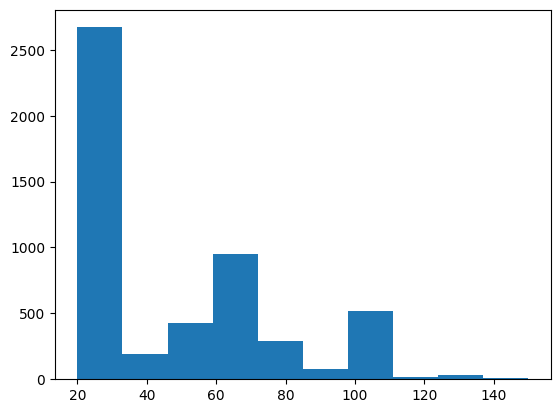

In [ ]:
temperature_all = negishi_df["Max Temperature"]
# check minimum and maximum temperatures (these may be outliers)
print("min:", temperature_all.min())
print("max:", temperature_all.max())
# plot distribution of temperatures excluding outliers
plot = temperature_all.hist(grid=False)

In [ ]:
# temperature solvent
temperature_tiles = pd.qcut(temperature_all, 10, duplicates="drop")
temperature_tiles.to_frame()
negishi_df["Max Temperature Quantiles"] = temperature_tiles.apply(str)
temps = [[str(i)] for i in temperature_tiles]
temp_mlb = MultiLabelBinarizer()
temp_encoded = pd.DataFrame(
    temp_mlb.fit_transform(temps), columns=temp_mlb.classes_, index=negishi_df.index
)
temp_encoded

,"(100.0, 150.0]","(19.999, 25.0]","(25.0, 50.0]","(50.0, 60.0]","(60.0, 70.0]","(70.0, 100.0]"
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
5183,0,0,1,0,0,0
5184,0,0,0,0,1,0
5185,1,0,0,0,0,0
5186,1,0,0,0,0,0


In [ ]:
temperature_data = negishi_df["Max Temperature"].apply(int_to_binary)
columns = [str(2 ** (i - 1)) for i in range(8, 0, -1)]
temp_binary_encoded = pd.DataFrame(temperature_data.tolist(), columns=columns)
temp_binary_encoded

,128,64,32,16,8,4,2,1
0,0,0,0,1,1,0,0,1
1,0,0,1,0,1,0,0,0
2,0,0,0,1,1,0,0,1
3,0,0,0,1,0,1,0,0
4,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...
5183,0,0,1,0,1,1,0,1
5184,0,1,0,0,0,0,0,1
5185,0,1,1,0,1,1,1,0
5186,0,1,1,0,1,1,1,0


In [ ]:
# label reagent
reagent_mlb = MultiLabelBinarizer()
reagent_encoded = pd.DataFrame(
    reagent_mlb.fit_transform(negishi_df["Reagents"]),
    columns=reagent_mlb.classes_,
    index=negishi_df.index,
)
reagent_encoded

,"(1,1'-bis(diphenylphosphino)ferrocene)palladium(II) dichloride",(2-phenylethyl)diphenylphosphane,"(4R,4'R)-2,2'-(cyclopentane-1,1-diyl)bis(4-isopropyl-4,5-dihydrooxazole)","(4S,4'S)-2,2'-(cyclopentane-1,1-diyl)bis(4-iso-propyl-4,5-dihydrooxazole)","(E)-1,4-bis(2,2-dioxido-3,3a,4,8b-tetrahydro-1H-indeno[1,2-c]isothiazol-1-yl)but-2-ene-1,4-dione","(S,S)-2,2'-isopropylidenebis(4-phenyl-2-oxazoline)",(trimethylsilyl)methylzinc iodide,"1,1'-bis-(diphenylphosphino)ferrocene","1,1-Dibromoethane","1,10-Phenanthroline",...,tris-(o-tolyl)phosphine,urea,water,zinc,zinc copper,zinc dibromide,"zinc dichloro(N,N,N′,N′-tetramethylethylenediamine)",zinc dimethoxide,zinc(II) chloride,zirconocene dichloride
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# label solvent
sol_mlb = MultiLabelBinarizer()
sol_encoded = pd.DataFrame(
    sol_mlb.fit_transform(negishi_df["Solvent (Reaction Details)"]),
    columns=sol_mlb.classes_,
    index=negishi_df.index,
)
sol_encoded

,"1,2-dimethoxyethane","1,4-dioxane",1-ethyl-2-pyrrolidinone,1-methyl-pyrrolidin-2-one,2-methyltetrahydrofuran,"N,N-dimethyl acetamide","N,N-dimethyl-formamide",acetonitrile,benzene,dichloromethane,...,ethylene dibromide,hexane,lithium hydroxide monohydrate,n-heptane,pentane,tetrahydrofuran,tetramethylurea,toluene,trifluoroacetic acid,water
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5185,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5186,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
for key in ["Solvent (Reaction Details)", "Reagents"]:
    negishi_df[key] = negishi_df[key].apply(tuple)
filtered_negishi_df = negishi_df.drop_duplicates(
    subset=[
        "Reaction ID",
        "Max Temperature",
        "Solvent (Reaction Details)",
        "Reagents",
        "Max Temperature Quantiles",
    ]
)
filtered_index = filtered_negishi_df.index
for key in ["Solvent (Reaction Details)", "Reagents"]:
    filtered_negishi_df[key] = filtered_negishi_df[key].apply(list)
filtered_negishi_df.to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/negishi/filtered_negishi.csv",
    index=False,
)
temp_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/negishi/filtered_negishi_temp.csv",
    index=False,
)
temp_binary_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/negishi/filtered_negishi_binary_temp.csv",
    index=False,
)
reagent_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/negishi/filtered_negishi_reagent.csv",
    index=False,
)
sol_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/negishi/filtered_negishi_sol.csv",
    index=False,
)

## buchwald reactions

In [ ]:
data_path = "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/buchwald/buchwald.csv"
buchwald_df = pd.read_csv(data_path)
buchwald_df["Reagents"] = buchwald_df["Reagents"].apply(ast.literal_eval)
buchwald_df["Solvent (Reaction Details)"] = buchwald_df[
    "Solvent (Reaction Details)"
].apply(ast.literal_eval)
buchwald_df = buchwald_df[
    (buchwald_df["Max Temperature"] >= 20) & (buchwald_df["Max Temperature"] <= 150)
]
buchwald_df = buchwald_df.reset_index(drop=True)
buchwald_df

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,20 - 110,110,"[N,N-dimethyl-formamide]","[copper (I) iodide, potassium carbonate]","['C1CCNC1', 'ClC1=CC=C(C=C1)N(=O)=O']",['O=N(=O)C1=CC=C(C=C1)N1CCCC1'],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
1,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,80,80,"[N,N-dimethyl-formamide]",[potassium carbonate],"['C1CCNC1', 'ClC1=CC=C(C=C1)N(=O)=O']",['O=N(=O)C1=CC=C(C=C1)N1CCCC1'],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,95.0
2,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,120,120,[neat (no solvent)],[potassium carbonate],"['C1CCNC1', 'ClC1=CC=C(C=C1)N(=O)=O']",['O=N(=O)C1=CC=C(C=C1)N1CCCC1'],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,92.0
3,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,130,130,"[N,N-dimethyl-formamide]","[copper(l) iodide, caesium carbonate, copper (...","['C1CCNC1', 'ClC1=CC=C(C=C1)N(=O)=O']",['O=N(=O)C1=CC=C(C=C1)N1CCCC1'],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,91.0
4,4036,C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O>>O=N(=O)C1=CC=C...,100,100,[iso-butanol],"[copper(l) iodide, potassium carbonate]","['C1CCNC1', 'ClC1=CC=C(C=C1)N(=O)=O']",['O=N(=O)C1=CC=C(C=C1)N1CCCC1'],C1CCNC1.ClC1=CC=C(C=C1)N(=O)=O,O=N(=O)C1=CC=C(C=C1)N1CCCC1,84.5
...,...,...,...,...,...,...,...,...,...,...,...
15469,42319595,COC(=O)[C@H](NC(=O)[C@@H](CCCNC(=N)NS(=O)(=O)C...,70,70,"[1,4-dioxane]","[copper(l) iodide, potassium carbonate, trans-...",['COC(=O)[C@H](NC(=O)[C@@H](CCCNC(=N)NS(=O)(=O...,['COC(=O)[C@H](NC(=O)[C@@H](CCCNC(=N)NS(=O)(=O...,COC(=O)[C@H](NC(=O)[C@@H](CCCNC(=N)NS(=O)(=O)C...,COC(=O)[C@H](NC(=O)[C@@H](CCCNC(=N)NS(=O)(=O)C...,2.5
15470,54035287,CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCCC...,100,100,[toluene],"[1,1'-bis-(diphenylphosphino)ferrocene, sodium...",['CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CC...,['CCCCCCC1=CC=C(S1)C1=CC(NC2=C(Br)C=C(NC3=C(C=...,CCCCCCC1=CC=C(S1)C1=CC(N)=C(C=C1N)C1=CC=C(CCCC...,CCCCCCC1=CC=C(S1)C1=CC(NC2=C(Br)C=C(NC3=C(C=CC...,2.0
15471,55378803,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,80,80,[toluene],"[sodium t-butanolate, trineopentyl phosphine, ...","['CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C', 'CC(C)...",['CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C...,CC1=C(N)C(=CC(=C1)C(C)(C)C)C(C)(C)C.CC(C)(C)C1...,CC1=CC(=CC(=C1NC1=C(C=C(C=C1)C(C)(C)C)C(C)(C)C...,2.0
15472,37131219,CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC>>CCOC(=O)C1=N...,90,90,"[1,4-dioxane]","[4,5-bis(diphenylphosphino)-9,9-dimethylxanthe...","['CCOC(=O)C1=NC(C)=C(Br)C=C1', 'CCNCC']",['CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC'],CCOC(=O)C1=NC(C)=C(Br)C=C1.CCNCC,CCOC(=O)C1=NC(C)=C(C=C1)N(CC)CC,1.0


min: 20
max: 150


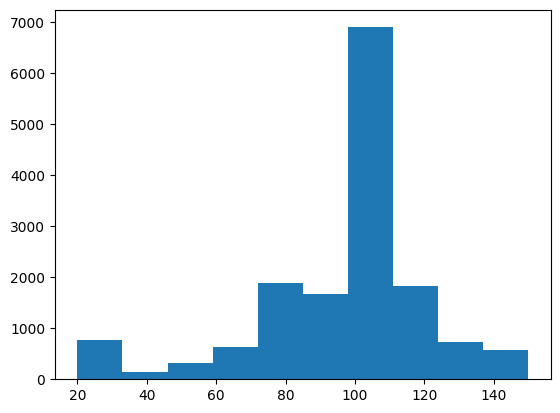

In [ ]:
temperature_all = buchwald_df["Max Temperature"]
# check minimum and maximum temperatures (these may be outliers)
print("min:", temperature_all.min())
print("max:", temperature_all.max())
# plot distribution of temperatures excluding outliers
plot = temperature_all.hist(grid=False)

In [ ]:
# temperature solvent
temperature_tiles = pd.qcut(temperature_all, 10, duplicates="drop")
temperature_tiles.to_frame()
buchwald_df["Max Temperature Quantiles"] = temperature_tiles.apply(str)
temps = [[str(i)] for i in temperature_tiles]
temp_mlb = MultiLabelBinarizer()
temp_encoded = pd.DataFrame(
    temp_mlb.fit_transform(temps), columns=temp_mlb.classes_, index=buchwald_df.index
)
temp_encoded

,"(100.0, 105.0]","(105.0, 110.0]","(110.0, 115.0]","(115.0, 120.0]","(120.0, 150.0]","(19.999, 65.0]","(65.0, 80.0]","(80.0, 90.0]","(90.0, 100.0]"
0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
15469,0,0,0,0,0,0,1,0,0
15470,0,0,0,0,0,0,0,0,1
15471,0,0,0,0,0,0,1,0,0
15472,0,0,0,0,0,0,0,1,0


In [ ]:
temperature_data = buchwald_df["Max Temperature"].apply(int_to_binary)
columns = [str(2 ** (i - 1)) for i in range(8, 0, -1)]
temp_binary_encoded = pd.DataFrame(temperature_data.tolist(), columns=columns)
temp_binary_encoded

,128,64,32,16,8,4,2,1
0,0,1,1,0,1,1,1,0
1,0,1,0,1,0,0,0,0
2,0,1,1,1,1,0,0,0
3,1,0,0,0,0,0,1,0
4,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
15469,0,1,0,0,0,1,1,0
15470,0,1,1,0,0,1,0,0
15471,0,1,0,1,0,0,0,0
15472,0,1,0,1,1,0,1,0


In [ ]:
# label reagent
reagent_mlb = MultiLabelBinarizer()
reagent_encoded = pd.DataFrame(
    reagent_mlb.fit_transform(buchwald_df["Reagents"]),
    columns=reagent_mlb.classes_,
    index=buchwald_df.index,
)
reagent_encoded

,"(1,1'-bis(diphenylphosphino)ferrocene)palladium(II) dichloride","(1,3-bis(2,6-diisopropylphenyl)-4,5-dihydroimidazol-2-ylidene) (3-chloropyridyl) palladium(II) dichloride","(1R,2R)-1,2-diaminocyclohexane",(2-furyl)methyl alcohol,(2-hydroxyphenyl)morpholin-4-yl-methanone,(2-mesityl-1H-inden-3-yl)dicyclohexyl phosphine,"(2R)-1-[(1R)-1-[bis(1,1-dimethylethyl)phosphino]ethyl]-2-(dicyclohexylphosphino)ferrocene",(E)-3-(dimethylamino)-1-(2-hydroxyphenyl)prop-2-en-1-one,"(S,S)-1,2-diaminocyclohexane","1,1'-bi-2-naphthol",...,trineopentyl phosphine,triphenylphosphine,"tris((1E,4E)-1,5- diphenylpenta-1,4-dien-3-one) dipalladium",tris(1-methylethyl)phosphine,tris-(dibenzylideneacetone)dipalladium(0),tris-(o-tolyl)phosphine,water,zinc,zinc diacetate,"α,α,α-trifluorotoluene"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
15471,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
15472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# label solvent
sol_mlb = MultiLabelBinarizer()
sol_encoded = pd.DataFrame(
    sol_mlb.fit_transform(buchwald_df["Solvent (Reaction Details)"]),
    columns=sol_mlb.classes_,
    index=buchwald_df.index,
)
sol_encoded

,"1,2-dichloro-benzene","1,2-dimethoxyethane","1,4-dioxane",1-methyl-pyrrolidin-2-one,2-methyltetrahydrofuran,"5,5-dimethyl-1,3-cyclohexadiene",Dimethyl ether,"N,N-dimethyl acetamide","N,N-dimethyl-formamide",acetonitrile,...,neat (no solvent),o-xylene,para-xylene,sulfolane,tert-Amyl alcohol,tert-butyl alcohol,tert-butyl methyl ether,tetrahydrofuran,toluene,water
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15472,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for key in ["Solvent (Reaction Details)", "Reagents"]:
    buchwald_df[key] = buchwald_df[key].apply(tuple)
filtered_buchwald_df = buchwald_df.drop_duplicates(
    subset=[
        "Reaction ID",
        "Max Temperature",
        "Solvent (Reaction Details)",
        "Reagents",
        "Max Temperature Quantiles",
    ]
)
filtered_index = filtered_buchwald_df.index
for key in ["Solvent (Reaction Details)", "Reagents"]:
    filtered_buchwald_df[key] = filtered_buchwald_df[key].apply(list)
filtered_buchwald_df.to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/buchwald/filtered_buchwald.csv",
    index=False,
)
temp_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/buchwald/filtered_buchwald_temp.csv",
    index=False,
)
temp_binary_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/buchwald/filtered_buchwald_binary_temp.csv",
    index=False,
)
reagent_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/buchwald/filtered_buchwald_reagent.csv",
    index=False,
)
sol_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/buchwald/filtered_buchwald_sol.csv",
    index=False,
)

## suzuki reactions

In [ ]:
data_path = (
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/suzuki/suzuki.csv"
)
suzuki_df = pd.read_csv(data_path)
suzuki_df["Reagents"] = suzuki_df["Reagents"].apply(ast.literal_eval)
suzuki_df["Solvent (Reaction Details)"] = suzuki_df["Solvent (Reaction Details)"].apply(
    ast.literal_eval
)
suzuki_df = suzuki_df[
    (suzuki_df["Max Temperature"] >= 20) & (suzuki_df["Max Temperature"] <= 150)
]
suzuki_df = suzuki_df.reset_index(drop=True)
suzuki_df

,Reaction ID,Reaction,Temperature (Reaction Details) [C],Max Temperature,Solvent (Reaction Details),Reagents,Reactants,Products,Reactants Smiles,Products Smiles,Yield (numerical)
0,32433079,CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,80,80,"[1,2-dimethoxyethane, water]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","['CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1', 'C...",['COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1'],CC1(C)OB(OC1(C)C)C1=CC=C(OC2CCCCO2)C=C1.COC1=C...,COC1=CC=C(CC(O)CO)C=C1C1=CC=C(OC2CCCCO2)C=C1,99.000
1,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,100,100,"[N,N-dimethyl-formamide, water]","[sodium carbonate, tetrakis(triphenylphosphine...","['COC1=CC=C(C=O)C(Br)=C1', 'OB(O)C1=CC=CC=C1']",['COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1'],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,99.000
2,32450974,COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1>>COC1=...,80,80,"[1,4-dioxane]","[N,N-diisopropyl-2-(4-methylstyryl)-benzamide,...","['COC1=CC=C(C=O)C(Br)=C1', 'OB(O)C1=CC=CC=C1']",['COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1'],COC1=CC=C(C=O)C(Br)=C1.OB(O)C1=CC=CC=C1,COC1=CC=C(C=O)C(=C1)C1=CC=CC=C1,94.000
3,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,[water],[potassium carbonate],"['BrC1=CN=CC=C1', 'CC1(C)OB(OC1(C)C)C1=CC=CC=C1']",['C1=CC=C(C=C1)C1=CC=CN=C1'],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,99.000
4,32495622,BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1>>C1...,20,20,"[ethanol, water]",[potassium carbonate],"['BrC1=CN=CC=C1', 'CC1(C)OB(OC1(C)C)C1=CC=CC=C1']",['C1=CC=C(C=C1)C1=CC=CN=C1'],BrC1=CN=CC=C1.CC1(C)OB(OC1(C)C)C1=CC=CC=C1,C1=CC=C(C=C1)C1=CC=CN=C1,85.000
...,...,...,...,...,...,...,...,...,...,...,...
94915,58809272,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,90,90,"[1,4-dioxane]","[(1,1'-bis(diphenylphosphino)ferrocene)palladi...","['CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O', 'CC(C)[C@@H...",['CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C...,CC1=CN=C(NC(=O)C2CC2)C=C1B(O)O.CC(C)[C@@H]1CNC...,CC(C)[C@@H]1CNC(=O)C2=CC(=NN12)C1=CC(NC(=O)C2C...,1.000
94916,47959922,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,90,90,"[N,N-dimethyl-formamide]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","['COC1=CC(C)=C2N=C(Br)SC2=C1', 'CCOCC1=NC2=CC(...",['CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3...,COC1=CC(C)=C2N=C(Br)SC2=C1.CCOCC1=NC2=CC(C)=CC...,CCOCC1=NC2=CC(C)=CC(C3=NC4=C(C)C=C(OC)C=C4S3)=...,0.996
94917,59754144,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,105,105,"[1,4-dioxane, lithium hydroxide monohydrate]","[palladium (II) [1,1'-bis(diphenylphosphanyl)f...",['CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC...,['CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=...,CC1(C)OB(OC1(C)C)C1=CC=C(C=C1)C(=O)NC1=CC=CC=C...,CC(C)(C)OC(=O)N1CCC[C@H](C1)N1N=C(C2=C1N=CN=C2...,0.780
94918,43272448,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,100,100,"[1,4-dioxane, water]","[dichloro(1,1'-bis(diphenylphosphanyl)ferrocen...","['CC1=NC=C(I)N1', '[H][C@@]1(CNC(=O)C1)[C@@H](...",['C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1...,CC1=NC=C(I)N1.[H][C@@]1(CNC(=O)C1)[C@@H](C)OC1...,C[C@@H](OC1=C2N(C=NC2=CC(=C1)C1=CN=C(C)N1)C1CC...,0.600


min: 20
max: 150


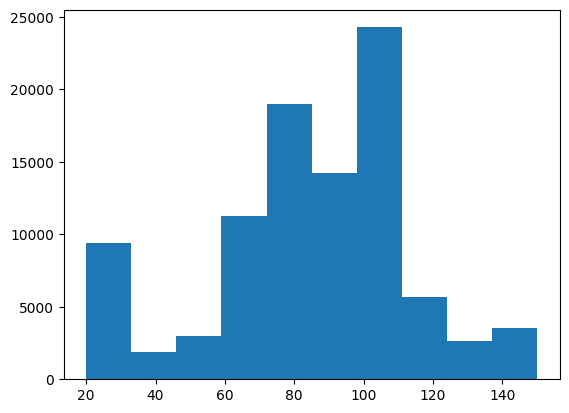

In [ ]:
temperature_all = suzuki_df["Max Temperature"]
# check minimum and maximum temperatures (these may be outliers)
print("min:", temperature_all.min())
print("max:", temperature_all.max())
# plot distribution of temperatures excluding outliers
plot = temperature_all.hist(grid=False)

In [ ]:
# temperature solvent
temperature_tiles = pd.qcut(temperature_all, 10, duplicates="drop")
temperature_tiles.to_frame()
suzuki_df["Max Temperature Quantiles"] = temperature_tiles.apply(str)
temps = [[str(i)] for i in temperature_tiles]
temp_mlb = MultiLabelBinarizer()
temp_encoded = pd.DataFrame(
    temp_mlb.fit_transform(temps), columns=temp_mlb.classes_, index=suzuki_df.index
)
temp_encoded

,"(100.0, 110.0]","(110.0, 120.0]","(120.0, 150.0]","(19.999, 35.0]","(35.0, 60.0]","(60.0, 80.0]","(80.0, 90.0]","(90.0, 95.0]","(95.0, 100.0]"
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
94915,0,0,0,0,0,0,1,0,0
94916,0,0,0,0,0,0,1,0,0
94917,1,0,0,0,0,0,0,0,0
94918,0,0,0,0,0,0,0,0,1


In [ ]:
temperature_data = suzuki_df["Max Temperature"].apply(int_to_binary)
columns = [str(2 ** (i - 1)) for i in range(8, 0, -1)]
temp_binary_encoded = pd.DataFrame(temperature_data.tolist(), columns=columns)
temp_binary_encoded

,128,64,32,16,8,4,2,1
0,0,1,0,1,0,0,0,0
1,0,1,1,0,0,1,0,0
2,0,1,0,1,0,0,0,0
3,0,0,0,1,0,1,0,0
4,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
94915,0,1,0,1,1,0,1,0
94916,0,1,0,1,1,0,1,0
94917,0,1,1,0,1,0,0,1
94918,0,1,1,0,0,1,0,0


In [ ]:
# label reagent
reagent_mlb = MultiLabelBinarizer()
reagent_encoded = pd.DataFrame(
    reagent_mlb.fit_transform(suzuki_df["Reagents"]),
    columns=reagent_mlb.classes_,
    index=suzuki_df.index,
)
reagent_encoded

,(+)-sodium L-ascorbate,"(1,1'-bis(diphenylphosphino)ferrocene)palladium(II) dichloride","(1,3,5-triaza-7-phosphaadamantan-1-ium-1-yl)butane-1-sulfonate","(1,3-bis(2,6-diisopropylphenyl)-4,5-dihydroimidazol-2-ylidene)chloro(3-phenylallyl)palladium(II)","(1,5-cyclooctadiene)(methoxy)iridium(I) dimer",(1-methylimidazol-2-yl)diphenylphosphine,"(1RS,2RS,3SR,4SR)-1,2,3,4-tetrakis((diphenylphosphanyl)methyl)cyclopentane","(1S,2S)-N,N'-dimethyl-1,2-diaminocyclohexane","(2,2'-bipyridine)nickel(II) dibromide",(2-mesityl-1H-inden-3-yl)-dicyclohexylphosphine,...,tris-(dibenzylideneacetone)dipalladium(0),tris-(m-sulfonatophenyl)phosphine,tris-(o-tolyl)phosphine,trisodium tris(3-sulfophenyl)phosphine,urea,water,zinc,zinc dibromide,zinc(II) chloride,zirconium(IV) fluoride
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94915,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# label solvent
sol_mlb = MultiLabelBinarizer()
sol_encoded = pd.DataFrame(
    sol_mlb.fit_transform(suzuki_df["Solvent (Reaction Details)"]),
    columns=sol_mlb.classes_,
    index=suzuki_df.index,
)
sol_encoded

,"1,2-Propanediol","1,2-dichloro-ethane","1,2-dimethoxyethane","1,3,5-trimethyl-benzene","1,3-dioxane","1,4-dioxane",1-Methyl-2-piperidone,1-methyl-pyrrolidin-2-one,"2,2,2-trifluoroethanol","2,4-dichlorophenoxyacetic acid dimethylamine",...,pentane,propan-1-ol,tert-Amyl alcohol,tert-butyl alcohol,tert-butyl methyl ether,tetrahydrofuran,toluene,water,water monomer,xylene
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94915,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94917,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94918,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
for key in ["Solvent (Reaction Details)", "Reagents"]:
    suzuki_df[key] = suzuki_df[key].apply(tuple)
filtered_suzuki_df = suzuki_df.drop_duplicates(
    subset=[
        "Reaction ID",
        "Max Temperature",
        "Solvent (Reaction Details)",
        "Reagents",
        "Max Temperature Quantiles",
    ]
)
filtered_index = filtered_suzuki_df.index
for key in ["Solvent (Reaction Details)", "Reagents"]:
    filtered_suzuki_df[key] = filtered_suzuki_df[key].apply(list)
filtered_suzuki_df.to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/suzuki/filtered_suzuki.csv",
    index=False,
)
temp_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/suzuki/filtered_suzuki_temp.csv",
    index=False,
)
temp_binary_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/suzuki/filtered_suzuki_binary_temp.csv",
    index=False,
)
reagent_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/suzuki/filtered_suzuki_reagent.csv",
    index=False,
)
sol_encoded.loc[filtered_index].to_csv(
    "/content/drive/MyDrive/SCL_Space/data/Reaxys/preprocessed_data/suzuki/filtered_suzuki_sol.csv",
    index=False,
)